# internet + road features
this is just to extract some features from internet (and road) traffic
has approximate changepoint/regime detection.

In [366]:
library(moments)

In [367]:
times <- format(seq(from = as.POSIXct("2018-08-02 00:00:00", tz="UTC"), to=as.POSIXct("2018-08-02 23:59:59", tz="UTC"), by="15 min"), "%H:%M")

In [368]:
count <- read.csv("../data/highways_england/all_london/count_2016-2018.csv")
speed <- read.csv("../data/highways_england/all_london/speed_2016-2018.csv")

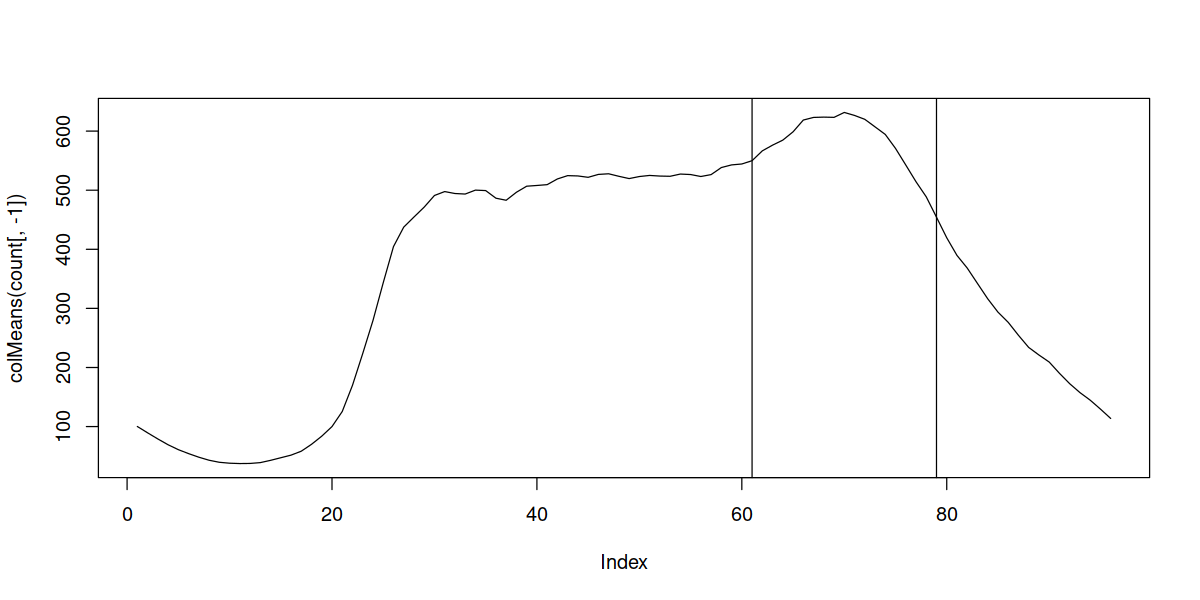

In [369]:
options(repr.plot.width=10, repr.plot.height=5)
plot(colMeans(count[, -1]), type="l")
abline(v=which(times == "15:00"))
abline(v=which(times == "19:30"))

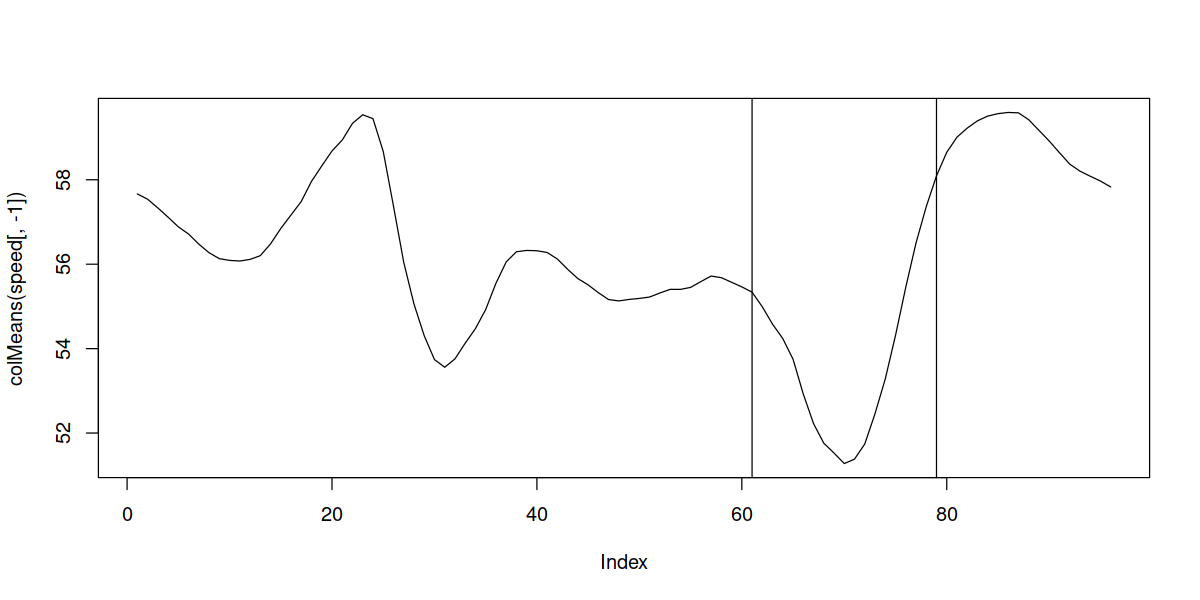

In [370]:
plot(colMeans(speed[, -1]), type="l")
abline(v=which(times == "15:00"))
abline(v=which(times == "19:30"))

## (fixed window) evening road commute features based on speed

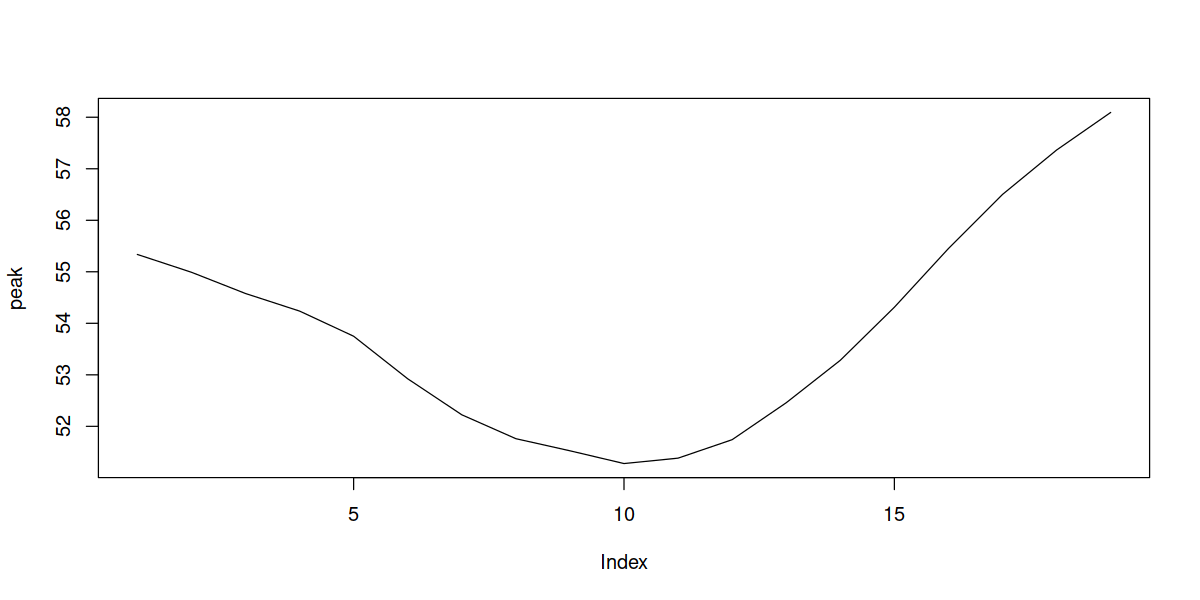

In [371]:
peak <- colMeans(speed[, -1])
peak <- peak[which(times == "15:00"):which(times == "19:30")]
plot(peak, type="l")

In [372]:
summary.stats <- function(x) {
    if(any(is.na(x))) return(NA)
    x <- smooth.spline(x, df=18)$y
    c(summary(x), sd=sd(x), skewness=skewness(x), kurtosis=kurtosis(x))
}

In [373]:
summary.stats(peak)

Min.    1st Qu.     Median       Mean    3rd Qu.       Max.         sd 
51.2825716 51.9933745 53.7434696 53.8520299 55.1629923 58.0939380  2.0688577 
  skewness   kurtosis 
 0.4918987  2.2389679

In [374]:
tail(count[, -1], 3)

X0    X1    X2    X3    X4    X5    X6    X7    X8    X9    ⋯ X86    X87   
976 58.79 53.11 47.18 41.07 36.37 31.12 26.70 24.63 22.89 20.95 ⋯ 131.97 127.58
977 68.02 60.54 52.37 48.31 42.14 38.00 33.00 29.74 26.20 25.48 ⋯ 124.98 117.03
978 51.45 48.19 38.73 34.99 28.77 27.07 23.47 20.16 17.05 18.34 ⋯  91.09  84.17
    X88    X89    X90    X91    X92   X93   X94   X95  
976 128.23 125.45 112.09 103.60 97.97 93.06 84.35 73.77
977 110.02 105.16  97.89  85.43 81.07 76.39 66.76 59.52
978  84.94  79.18  71.36  67.88 61.84 56.87 46.73 36.07

In [375]:
ncol(count[, -1]) == 24*60 / 15

[1] TRUE

In [376]:
# take above, stack rows to form [[date, interval, V], [date, interval, V]...]
flatten <- function(df) as.vector(matrix(t(df[, -1]), ncol=1))

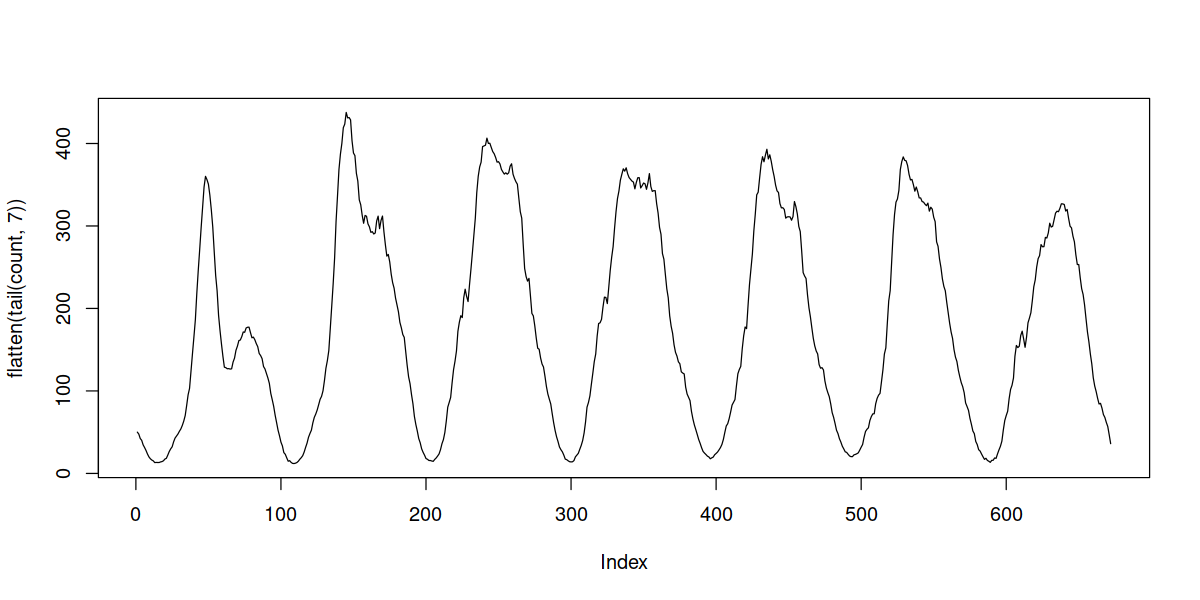

In [377]:
plot(flatten(tail(count, 7)), type="l")

In [378]:
suppressMessages(library(ixp))

In [379]:
lon2.2016.2017 <- lon2["2016/2018", ]
tail(lon2.2016.2017)

Warning message:
“timezone of object (UTC) is different than current timezone ().”

                       Bandwidth Weekday  MsM
2018-12-31 23:30:00 384094752763       2 1410
2018-12-31 23:35:00 382580831653       2 1415
2018-12-31 23:40:00 382015488061       2 1420
2018-12-31 23:45:00 376805101470       2 1425
2018-12-31 23:50:00 374710291045       2 1430
2018-12-31 23:55:00 370865655966       2 1435

In [380]:
min15.test <- period.apply(lon2.2016.2017["2017-12-31", ]$Bandwidth, endpoints(lon2.2016.2017["2016-12-31", ]$Bandwidth, "minutes", k=15), mean)
#min15.test <- to.minutes15(lon2.2016.2017["2016-12-31", ]$Bandwidth, OHLC=F)

In [381]:
nrow(min15.test)

[1] 96

In [382]:
head(min15.test, 1)

Warning message:
“timezone of object (UTC) is different than current timezone ().”

                       Bandwidth
2017-12-31 00:10:00 426337189004

In [383]:
mean(head(lon2.2016.2017["2017-12-31", ]$Bandwidth, 3))

[1] 426337189004

In [384]:
z <- period.apply(lon2.2016.2017$Bandwidth, endpoints(lon2.2016.2017$Bandwidth, "minutes", k=15), mean)

In [385]:
tail(z)

Warning message:
“timezone of object (UTC) is different than current timezone ().”

                       Bandwidth
2018-12-31 22:40:00 416942778583
2018-12-31 22:55:00 408327160454
2018-12-31 23:10:00 401260637748
2018-12-31 23:25:00 394000819102
2018-12-31 23:40:00 382897024159
2018-12-31 23:55:00 374127016160

In [386]:
tail(min15.test)

Warning message:
“timezone of object (UTC) is different than current timezone ().”

                       Bandwidth
2017-12-31 22:40:00 434277043163
2017-12-31 22:55:00 424172768552
2017-12-31 23:10:00 415367353524
2017-12-31 23:25:00 408375142947
2017-12-31 23:40:00 402604348429
2017-12-31 23:55:00 389764793408

In [387]:
summary(as.numeric(diff(index(lon2.2016.2017))))

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  5.000   5.000   5.000   5.002   5.000 495.000 

In [388]:
bw <- NULL
for(day in as.character(seq.Date(from=as.Date("2016-01-01"), to=as.Date("2018-12-31"), by=1))) {
    min.15 <- period.apply(lon2.2016.2017[day, ]$Bandwidth, endpoints(lon2.2016.2017[day, ]$Bandwidth, "minutes", k=15), mean)
    if(nrow(min.15) == 96) { # drop incomplete days.
        bw <- rbind(bw, cbind(min.15, interval=1:96))
    } else {
        warning(paste("drop", day))
    }
}
#z <- period.apply(lon2.2016.2017$Bandwidth, endpoints(lon2.2016.2017$Bandwidth, "minutes", k=15), mean)

Warning message in eval(expr, envir, enclos):
“drop 2018-05-19”

In [389]:
tail(bw)

Warning message:
“timezone of object (UTC) is different than current timezone ().”

                       Bandwidth interval
2018-12-31 22:40:00 416942778583       91
2018-12-31 22:55:00 408327160454       92
2018-12-31 23:10:00 401260637748       93
2018-12-31 23:25:00 394000819102       94
2018-12-31 23:40:00 382897024159       95
2018-12-31 23:55:00 374127016160       96

In [390]:
summary(as.numeric(diff(index(bw))))

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   5.00   15.00   15.00   15.01   15.00 1455.00 

In [391]:
traffic <- data.frame(date=as.Date(as.character(rep(count$X, each=96))), interval=1:96, count=flatten(count), speed=flatten(speed))

In [392]:
unique(table(traffic$interval))

[1] 978

In [393]:
head(traffic)

date       interval count  speed
1 2016-01-01 1         37.18 62.17
2 2016-01-01 2         45.27 62.50
3 2016-01-01 3         76.64 62.72
4 2016-01-01 4        105.16 62.72
5 2016-01-01 5        119.63 62.51
6 2016-01-01 6        129.62 62.42

In [394]:
tail(traffic)

date       interval count speed
93883 2018-12-31 91       71.36 54.19
93884 2018-12-31 92       67.88 54.17
93885 2018-12-31 93       61.84 54.47
93886 2018-12-31 94       56.87 54.57
93887 2018-12-31 95       46.73 54.60
93888 2018-12-31 96       36.07 54.47

In [395]:
traffic <- traffic[traffic$date <= as.Date("2018-12-31"), ] # clip

In [396]:
unique(table(traffic$interval))

[1] 978

In [397]:
nrow(count)

[1] 978

In [398]:
table(diff(unique(as.Date(index(bw)))))


   1    2 
1093    1 

In [399]:
# rm any bw dates not in road traffic dates
#bw <- bw[which(as.Date(index(bw)) %in% traffic$date), ]
date.intersection <- intersect(as.Date(index(bw)), traffic$date)
bw <- bw[as.Date(index(bw)) %in% date.intersection, ]
traffic <- traffic[traffic$date %in% date.intersection, ]

In [400]:
table(bw$interval)


  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18  19  20 
977 977 977 977 977 977 977 977 977 977 977 977 977 977 977 977 977 977 977 977 
 21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36  37  38  39  40 
977 977 977 977 977 977 977 977 977 977 977 977 977 977 977 977 977 977 977 977 
 41  42  43  44  45  46  47  48  49  50  51  52  53  54  55  56  57  58  59  60 
977 977 977 977 977 977 977 977 977 977 977 977 977 977 977 977 977 977 977 977 
 61  62  63  64  65  66  67  68  69  70  71  72  73  74  75  76  77  78  79  80 
977 977 977 977 977 977 977 977 977 977 977 977 977 977 977 977 977 977 977 977 
 81  82  83  84  85  86  87  88  89  90  91  92  93  94  95  96 
977 977 977 977 977 977 977 977 977 977 977 977 977 977 977 977 

In [401]:
length(unique(as.Date(index(bw))))

[1] 977

In [402]:
nrow(bw)

[1] 93792

In [403]:
nrow(traffic)

[1] 93792

In [404]:
combo <- data.frame(date=traffic$date, interval=bw$interval, bw=as.vector(bw$Bandwidth), road_count=traffic$count, road_speed=traffic$speed)
rownames(combo) <- NULL
head(combo)

date       interval bw           road_count road_speed
1 2016-01-01 1        275304863947  37.18     62.17     
2 2016-01-01 2        276368125415  45.27     62.50     
3 2016-01-01 3        273071635689  76.64     62.72     
4 2016-01-01 4        262154801056 105.16     62.72     
5 2016-01-01 5        266331261771 119.63     62.51     
6 2016-01-01 6        256438142364 129.62     62.42

In [405]:
#combo[which.min(combo$road_speed), ]

In [406]:
#hist(combo$road_speed, breaks=100, xlim = c(35, 70))

# heavy traffic
## lowest speed

In [407]:
is_weekend <- function(x) {
    wd <- weekdays(x)
    wd == "Saturday" | wd == "Sunday"
}

evening_commute <- function(df) {
    from <- which(times == "15:00")
    to <- which(times == "19:00")
    df[!is_weekend(df$date) & from <= df$interval & df$interval <= to, ]
}

In [408]:
evening.commute <- evening_commute(combo)
head(unique(combo[order(evening.commute$road_speed), ]$date), 9)

[1] "2016-02-09" "2016-01-13" "2016-05-16" "2016-01-14" "2016-01-20"
[6] "2016-05-12" "2016-03-11" "2016-04-01" "2016-01-11"

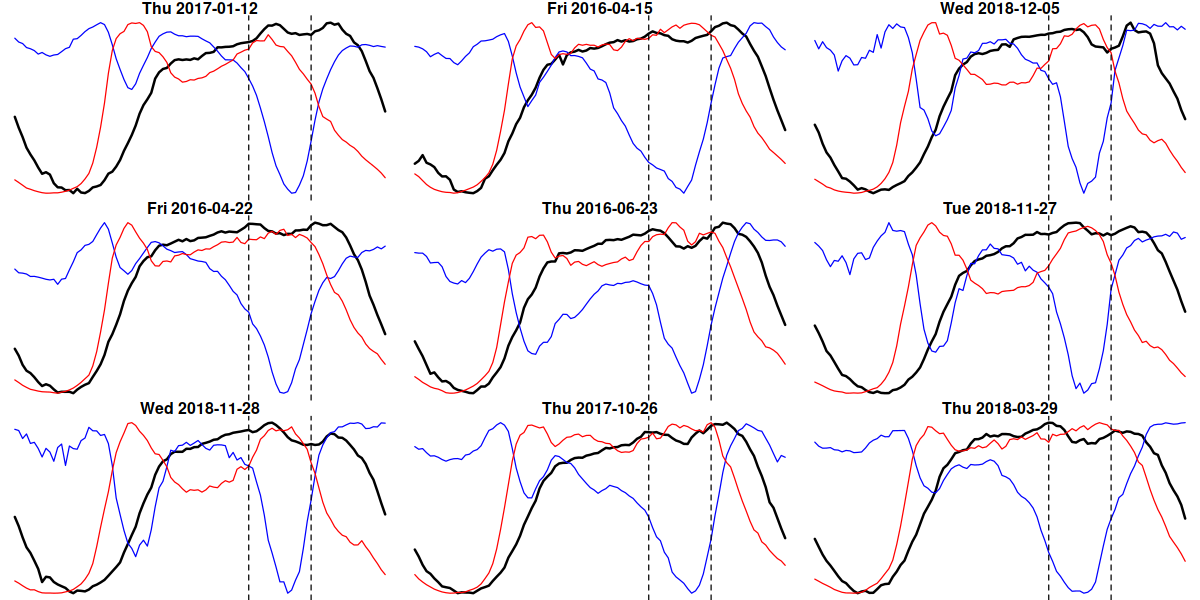

In [409]:
options(repr.plot.width=10, repr.plot.height=5)
par(mfrow=c(3,3),mar=c(0,0,1,0),bty="n",xaxt="n",yaxt="n")
for(d in head(unique(evening.commute[order(evening.commute$road_speed), ]$date), 9)) {
    with(combo[combo$date == d, ], {
        plot(bw, type="l",lwd=2,main=paste(weekdays(d), as.Date(d)))
        par(new=T)
        plot(road_speed, col="blue", type="l")
        par(new=T)
        plot(road_count, col="red", type="l")
        abline(v=which(times == "15:00"), lty=2)
        abline(v=which(times == "19:00"), lty=2)
    })
}

## highest traffic count

In [410]:
head(unique(combo[order(-evening.commute$road_count), ]$date), 9)

[1] "2016-02-17" "2016-02-18" "2016-02-16" "2016-02-23" "2016-03-09"
[6] "2016-03-08" "2016-02-25" "2016-03-22" "2016-02-26"

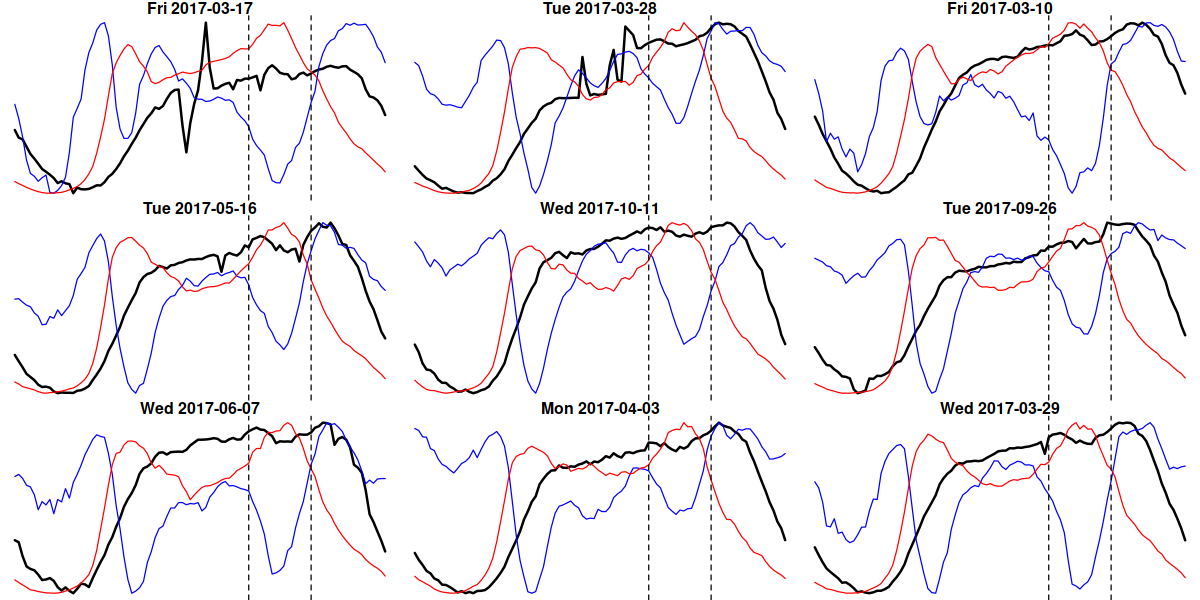

In [411]:
par(mfrow=c(3,3),mar=c(0,0,1,0),bty="n",xaxt="n",yaxt="n")
for(d in head(unique(evening.commute[order(-evening.commute$road_count), ]$date), 9)) {
    with(combo[combo$date == d, ], {
        plot(bw, type="l",lwd=2,main=paste(weekdays(d), as.Date(d)))
        par(new=T)
        plot(road_speed, col="blue", type="l")
        par(new=T)
        plot(road_count, col="red", type="l")
        abline(v=which(times == "15:00"), lty=2)
        abline(v=which(times == "19:00"), lty=2)
    })
}

# light traffic

## highest speed

note - these seem to be bank holidays.

In [412]:
# minimum evening commute speed per day (trough)
min.speed <- tapply(evening.commute$road_speed, evening.commute$date, min)
# highest trough speed dates.
max.min.speeds <- as.Date(names(sort(min.speed, decreasing = T)))

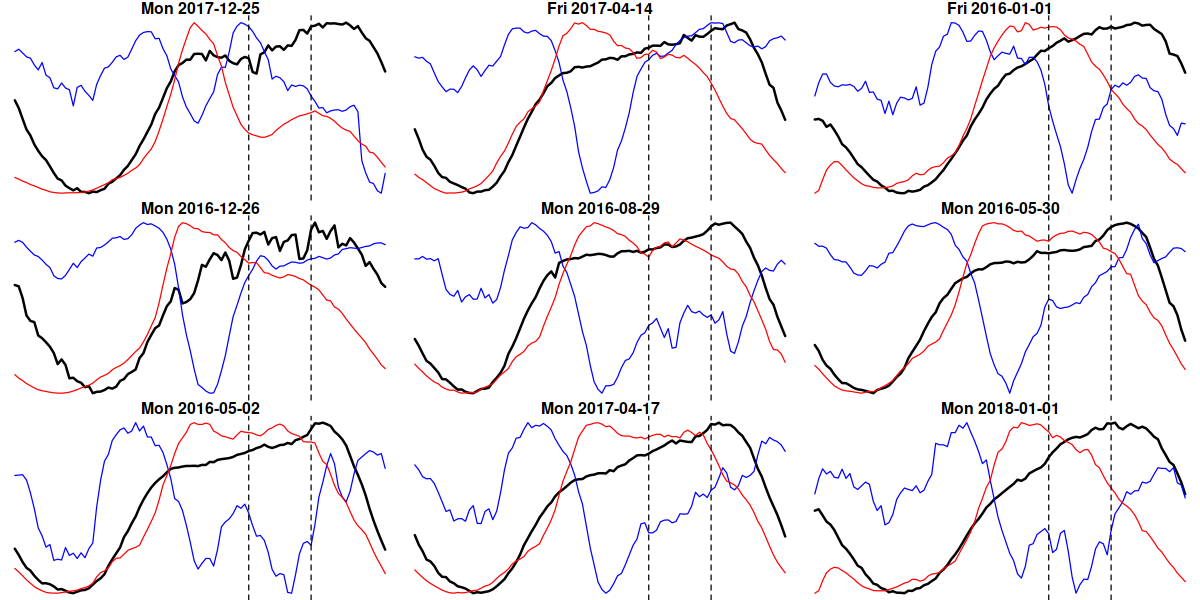

In [413]:
par(mfrow=c(3,3),mar=c(0,0,1,0),bty="n",xaxt="n",yaxt="n")
for(d in head(max.min.speeds, 9)) {
    with(combo[combo$date == d, ], {
        plot(bw, type="l",lwd=2,main=paste(weekdays(d), as.Date(d)))
        par(new=T)
        plot(road_speed, col="blue", type="l")
        par(new=T)
        plot(road_count, col="red", type="l")
        abline(v=which(times == "15:00"), lty=2)
        abline(v=which(times == "19:00"), lty=2)
    })
}

## lowest traffic count

In [414]:
# maximum evening commute count per day (peak)
max.count <- tapply(evening.commute$road_count, evening.commute$date, max)
# lowest peak count dates.
min.max.counts <- as.Date(names(sort(max.count, decreasing = F)))

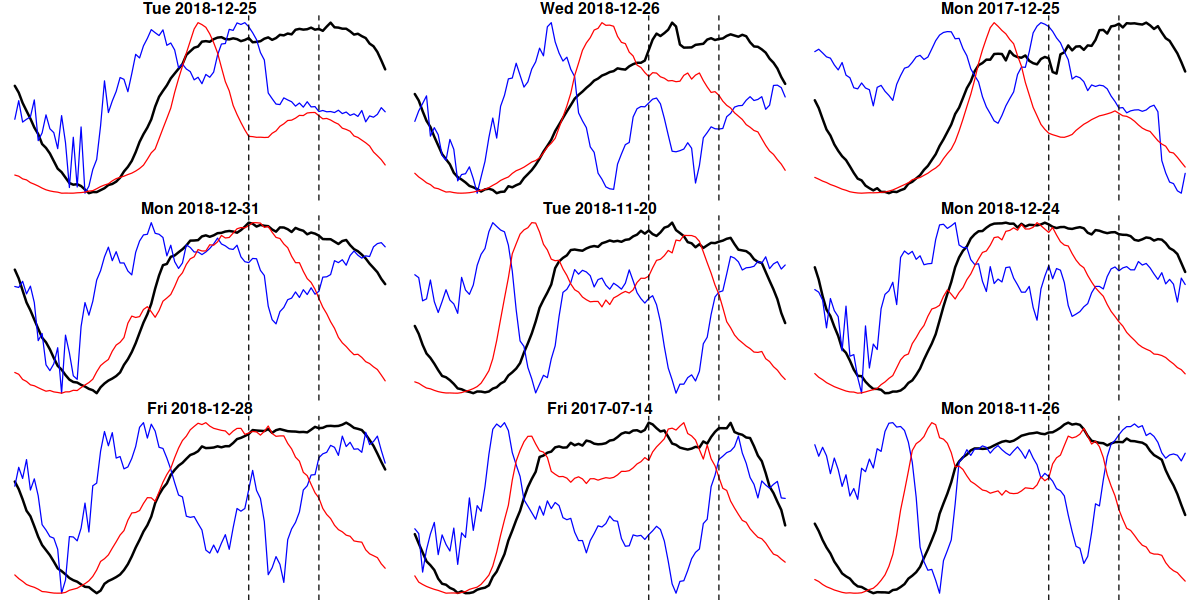

In [415]:
par(mfrow=c(3,3),mar=c(0,0,1,0),bty="n",xaxt="n",yaxt="n")
for(d in head(min.max.counts, 9)) {
    with(combo[combo$date == d, ], {
        plot(bw, type="l",lwd=2,main=paste(weekdays(d), as.Date(d)))
        par(new=T)
        plot(road_speed, col="blue", type="l")
        par(new=T)
        plot(road_count, col="red", type="l")
        abline(v=which(times == "15:00"), lty=2)
        abline(v=which(times == "19:30"), lty=2)
    })
}

In [416]:
test.day <- combo[combo$date == "2016-04-15", ]
test.period <- test.day[test.day$interval >= which(times == "14:00") & test.day$interval <= which(times == "21:00"), ]

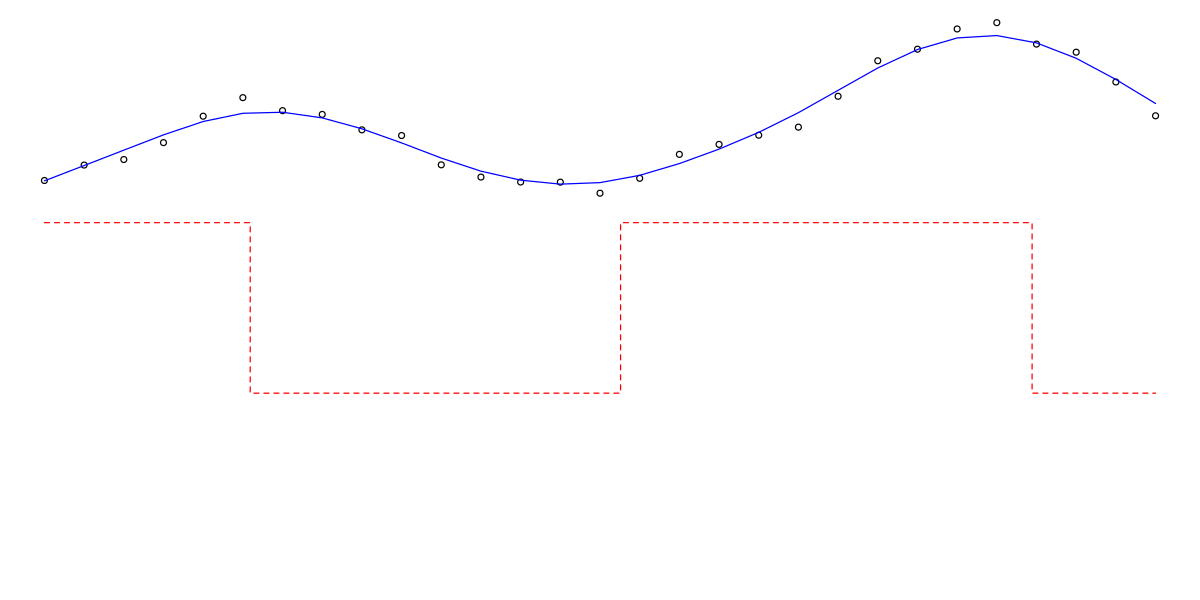

In [417]:
ts.spline <- smooth.spline(test.period$bw, df=8)
ts.loess <- predict(loess(bw ~ index(test.period), test.period, span=0.75))
par(mfrow=c(3,1),mar=c(0,0,1,0),bty="n",xaxt="n",yaxt="n")
plot(test.period$bw)
lines(ts.spline, col="blue")
#lines(ts.loess, col="red")
plot(sign(diff(test.period$bw)), type="s", lty=2, col="red")

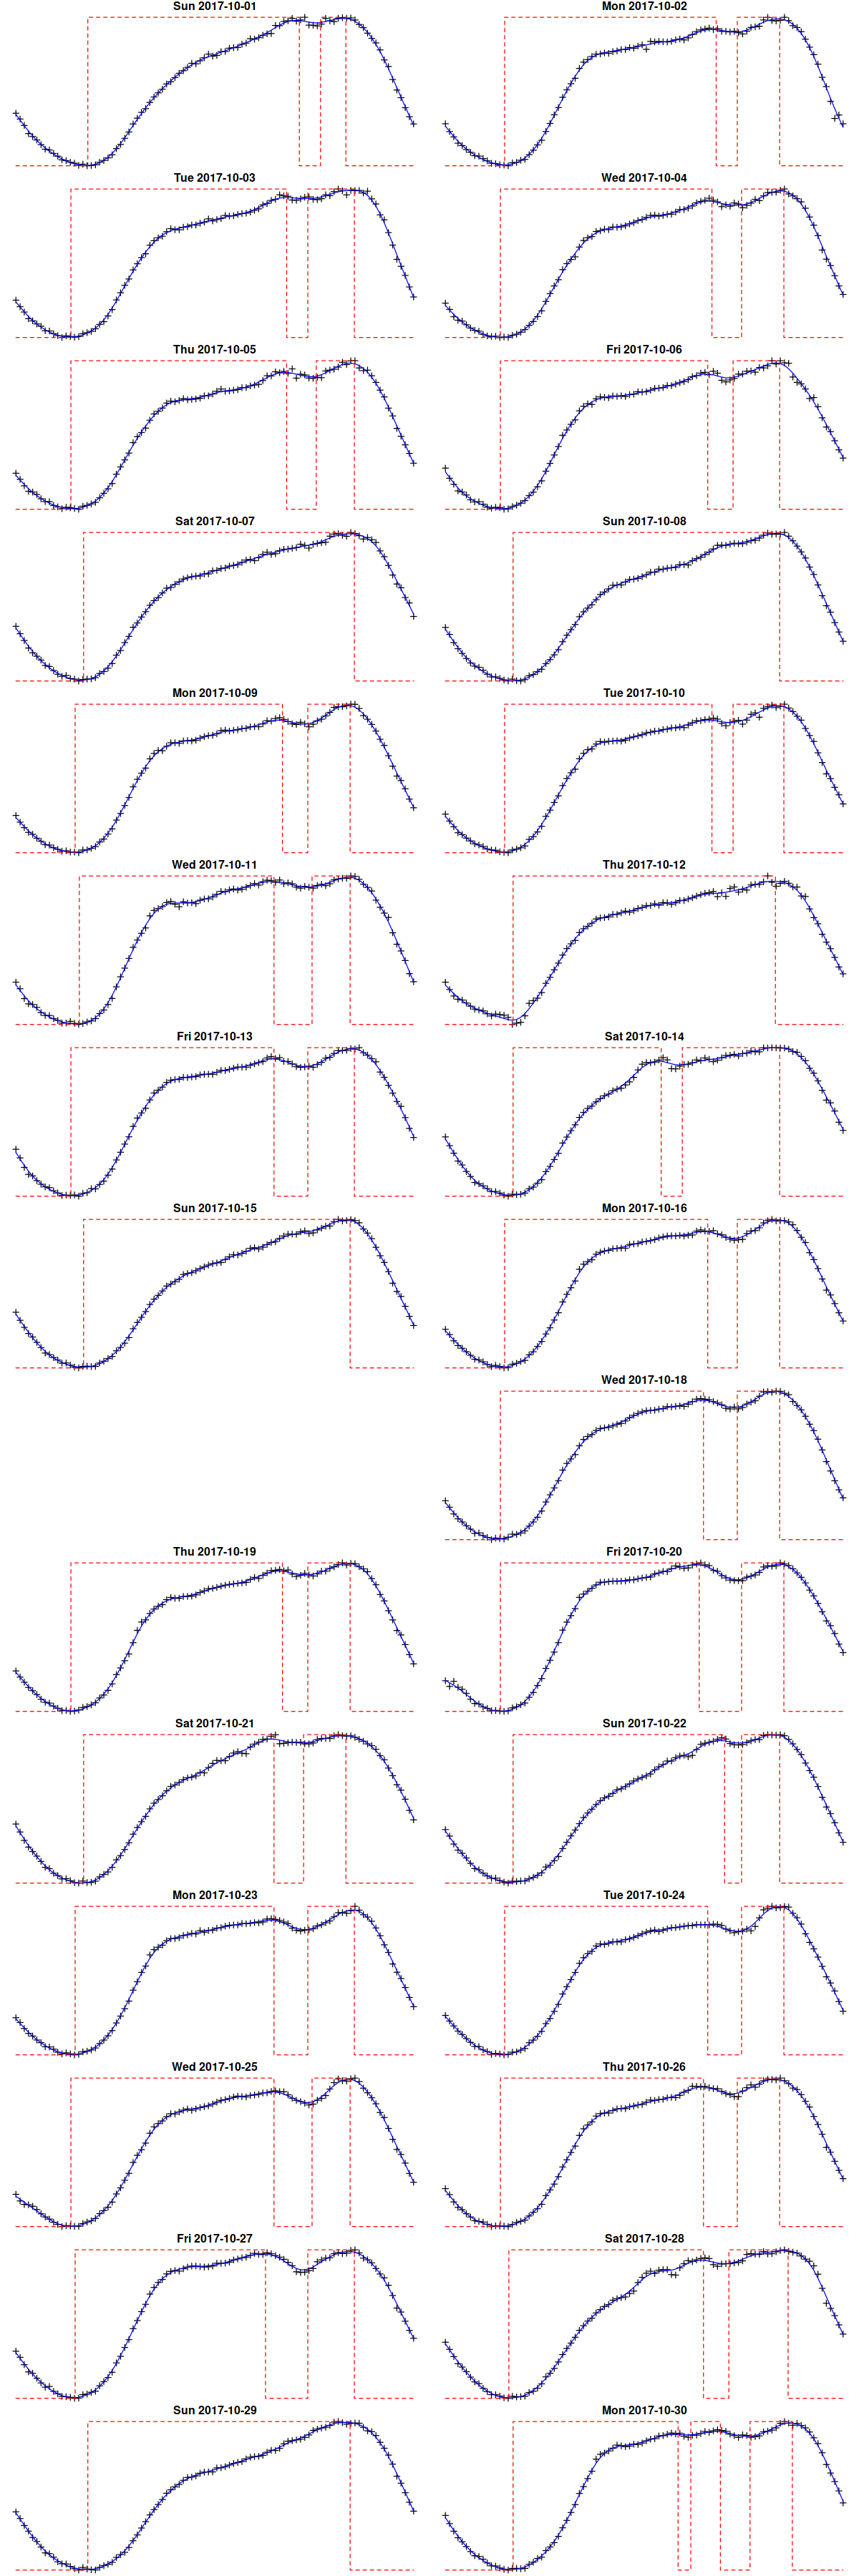

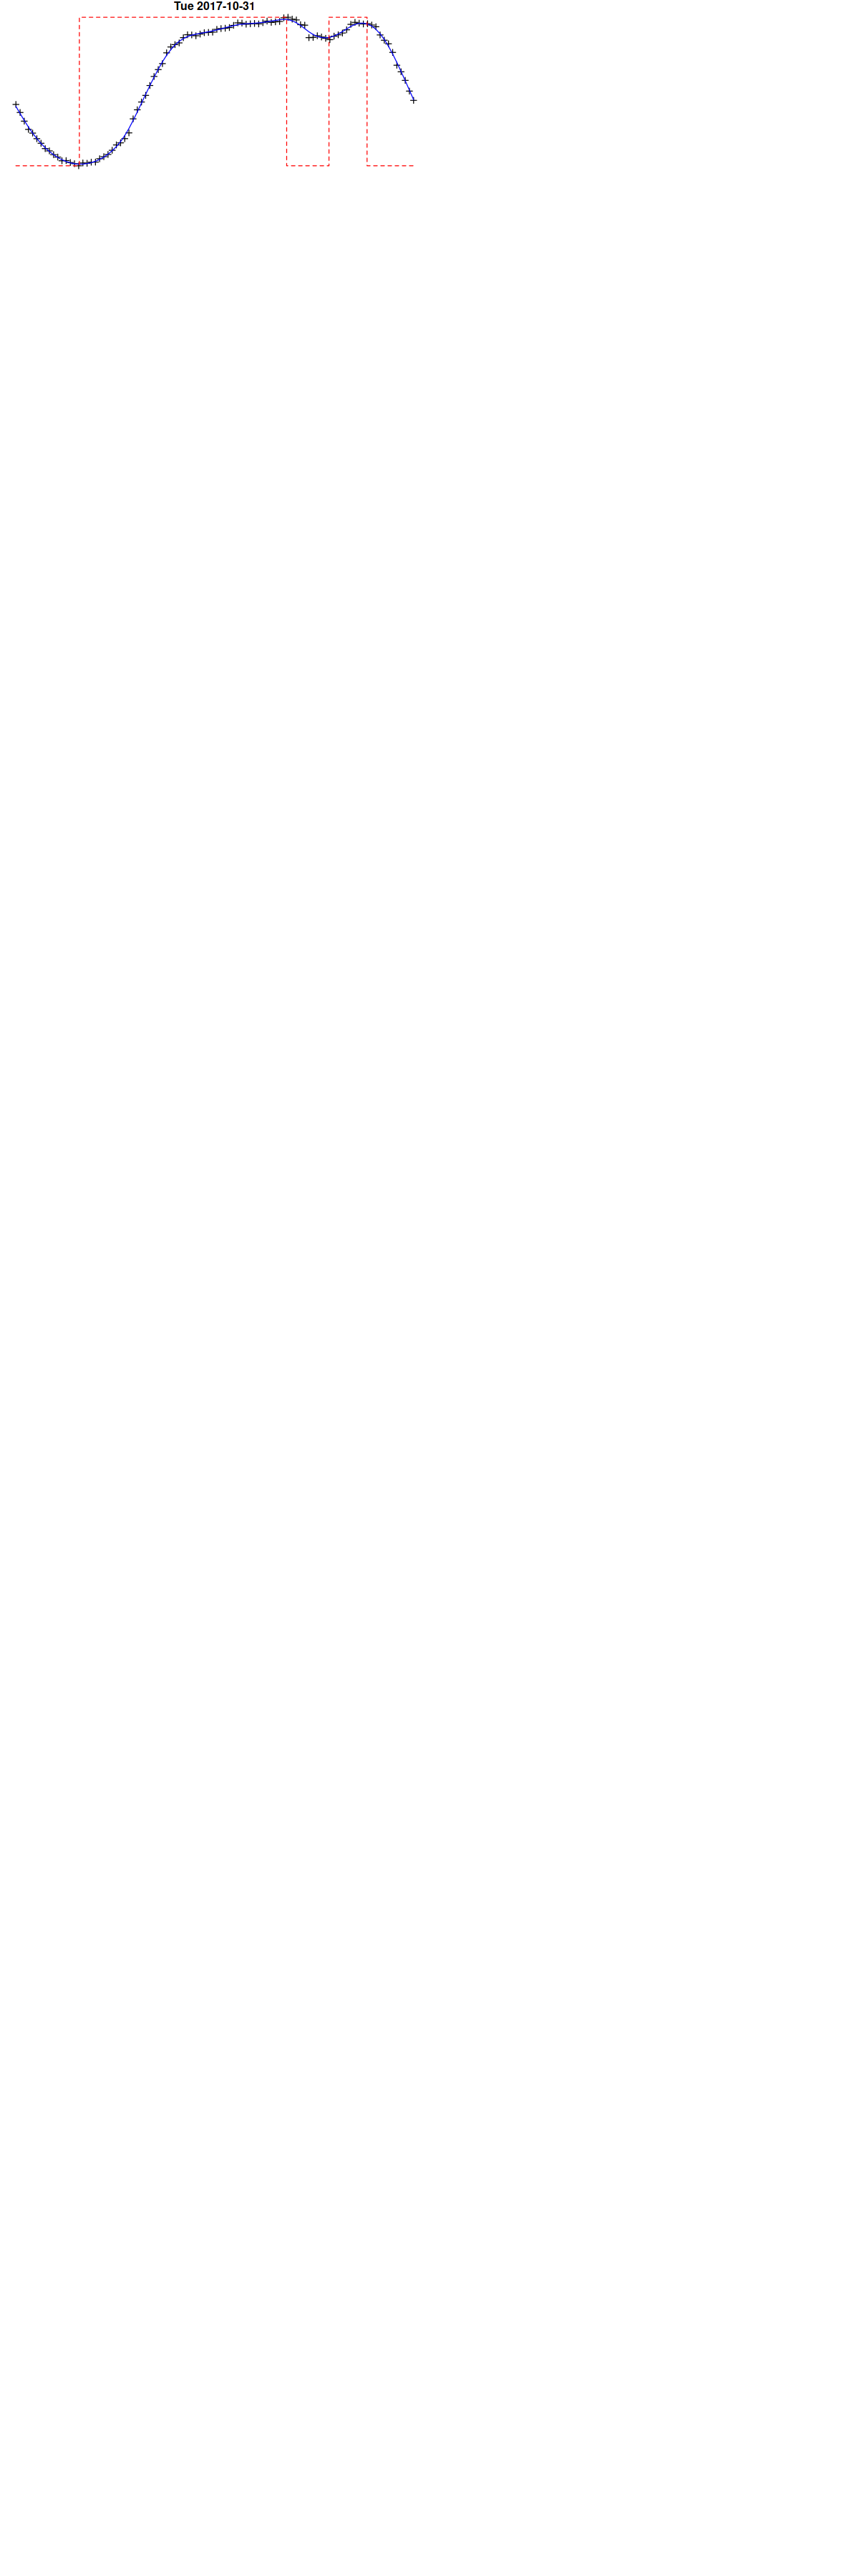

In [418]:
options(repr.plot.width=10, repr.plot.height=30)
par(mfrow=c(15,2),mar=c(0,0,1,0),bty="n",xaxt="n",yaxt="n")
for(d in seq(from=as.Date("2017-10-01"), to=as.Date("2017-10-31"), by=1)) {
    if(!d %in% unique(combo$date)) {
        plot(1, pch="")
    } else {
        
        #with(combo[combo$date == d & combo$interval >= which(times == "14:00") & combo$interval <= which(times == "23:00"), ], {
        with(combo[combo$date == d, ], {
        ts.spline <- smooth.spline(bw, df=19)
            plot(bw, main=paste(weekdays(d), as.Date(d)), pch=3)
            lines(ts.spline, col="blue")
            par(new=T)
            plot(sign(diff(ts.spline$y)), type="s", lty=2, col="red")
        })
    }
}

In [419]:
# phase lengths
d <- combo[combo$date == "2017-10-20", ]
ts.spline <- smooth.spline(d$bw, df=19)
phase.rle <- rle(sign(diff(ts.spline$y)))
phase.rle

Run Length Encoding
  lengths: int [1:5] 13 47 10 10 15
  values : num [1:5] -1 1 -1 1 -1

In [420]:
changepoints <- which(diff(sign(diff(ts.spline$y))) != 0)
changepoints

[1] 13 60 70 80

In [421]:
head(cumsum(phase.rle$lengths), -1)

[1] 13 60 70 80

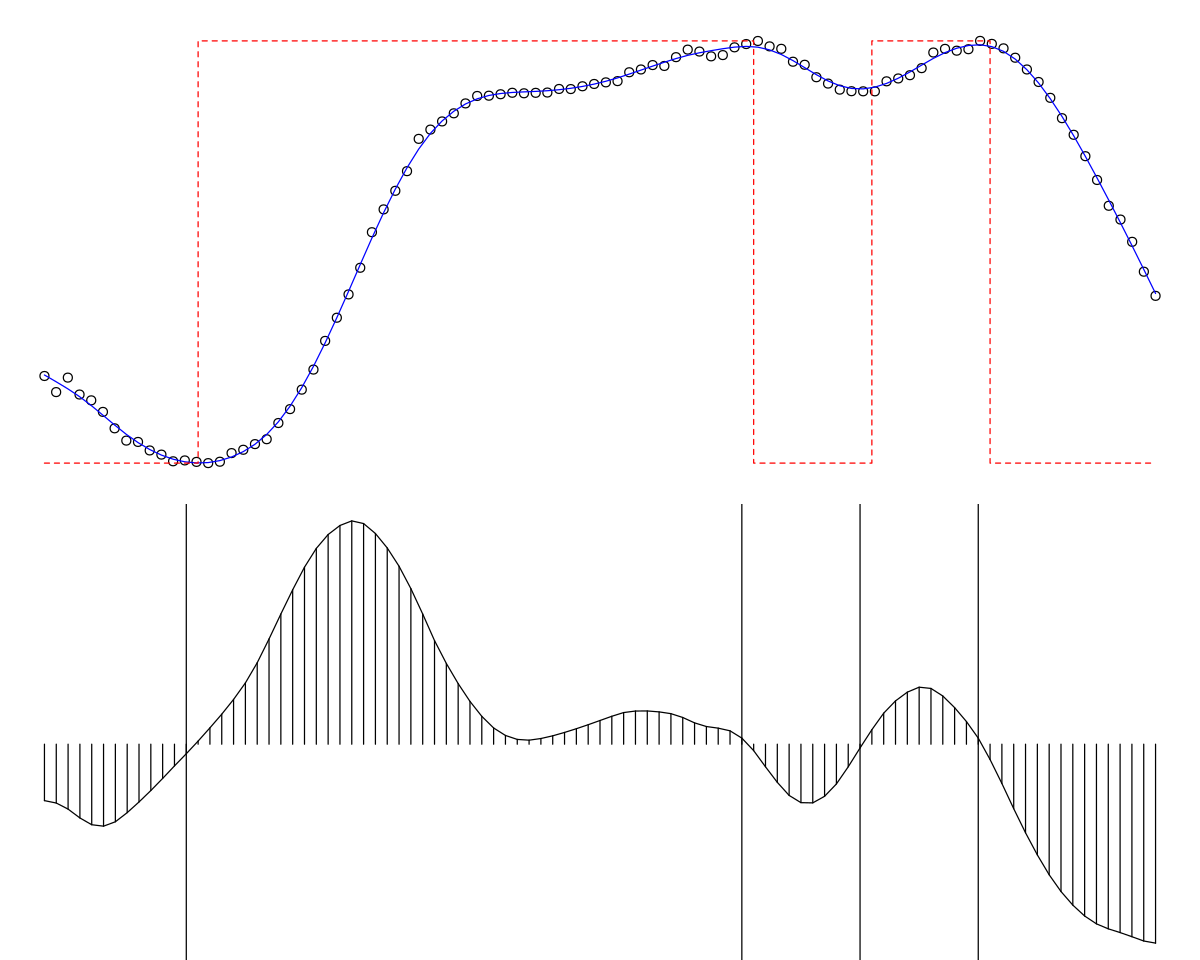

In [422]:
options(repr.plot.width=10, repr.plot.height=8)
par(mfrow=c(2,1),mar=c(0,0,1,0),bty="n",xaxt="n",yaxt="n")
plot(d$bw)
lines(ts.spline, col="blue")
par(new=T)
plot(sign(diff(ts.spline$y)), type="s", lty=2, col="red")
plot(diff(ts.spline$y), type="h")
lines(diff(ts.spline$y), type="l")
abline(v=changepoints)

In [423]:
# morning dip time
# pre "commute" peak time
# "commute" dip time
# evening peak time
phase_summary <- function(day, df=19) {
    a <- NA
    b <- NA
    c <- NA
    d <- NA
    ts.spline <- smooth.spline(day, df=df)
    changepoints <- which(c(NA, diff(sign(diff(ts.spline$y)))) != 0)
    N <- length(changepoints)
    if(N >= 2) {
        # morning dip is always the first one
        a <- changepoints[1]
        if(N >= 4) {
            # pre late afternoon dip is changepoint before penultimate
            b <- changepoints[N - 2]
            # late afternoon dip is penultimate changepoint
            c <- changepoints[N - 1]
        }
        # evening peak is always the last one
        d <- changepoints[N]
    }
    list(changepoint=c(a, b, c, d), value=day[c(a, b, c, d)])
}

In [424]:
phase_summary(d$bw)

$changepoint
[1] 14 61 71 81

$value
[1] 181587910053 548345929687 506854728115 551120272374

In [425]:
# 15 minute data bandwidth features
bandwidth.features.15 <- do.call(rbind, tapply(combo$bw, combo$date, function(x) do.call(c, phase_summary(x))))
head(bandwidth.features.15)

changepoint1 changepoint2 changepoint3 changepoint4 value1      
2016-01-01 24           NA           NA           84           143201613519
2016-01-02 23           67           70           78           148255137416
2016-01-03 23           NA           NA           81           154730341044
2016-01-04 20           66           72           83           149309530947
2016-01-05 19           68           74           83           158398997759
2016-01-06 19           68           73           83           156043396466
           value2       value3       value4      
2016-01-01           NA           NA 447568410858
2016-01-02 448651976932 436494853195 460622022743
2016-01-03           NA           NA 484740902206
2016-01-04 463899447370 449716249307 485632773399
2016-01-05 482857512750 464780480465 503016178806
2016-01-06 476713203245 468162283746 496313715220

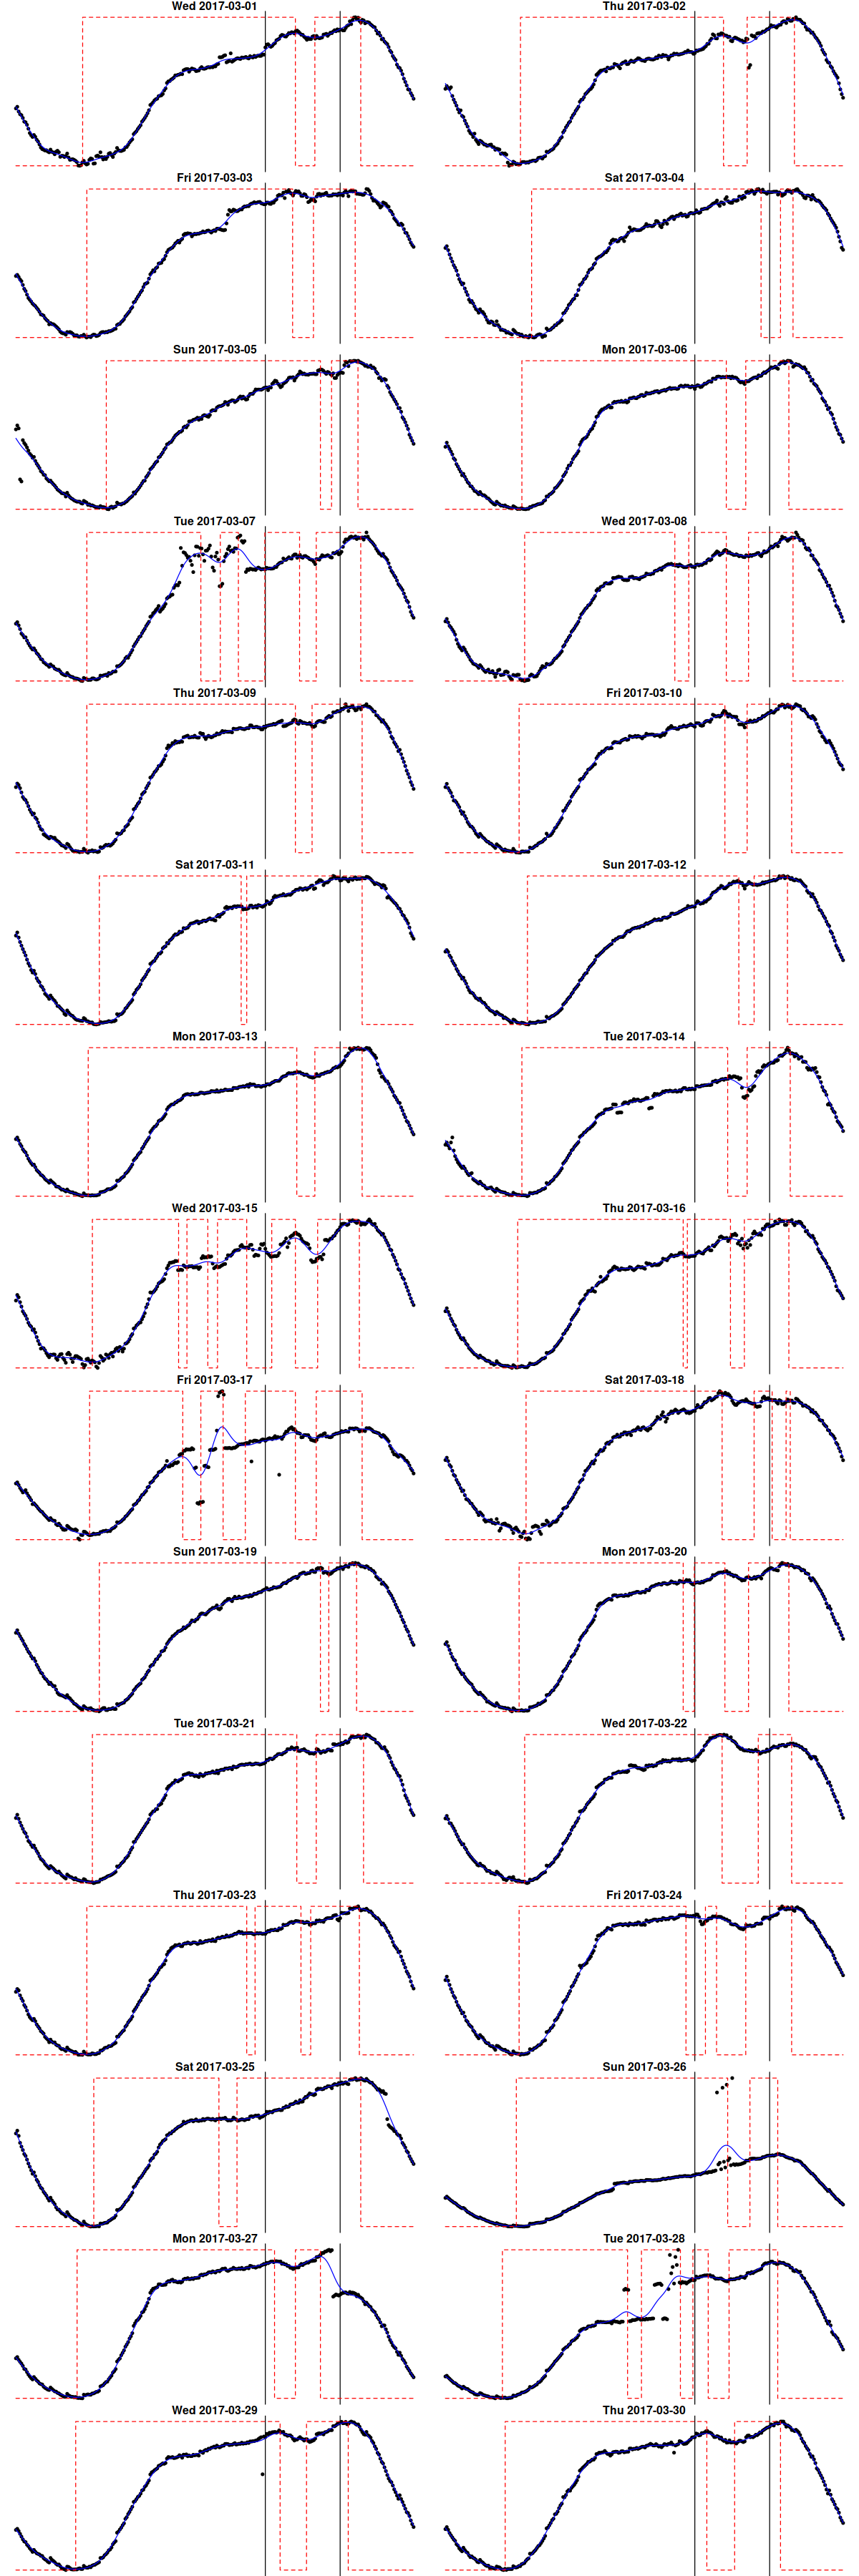

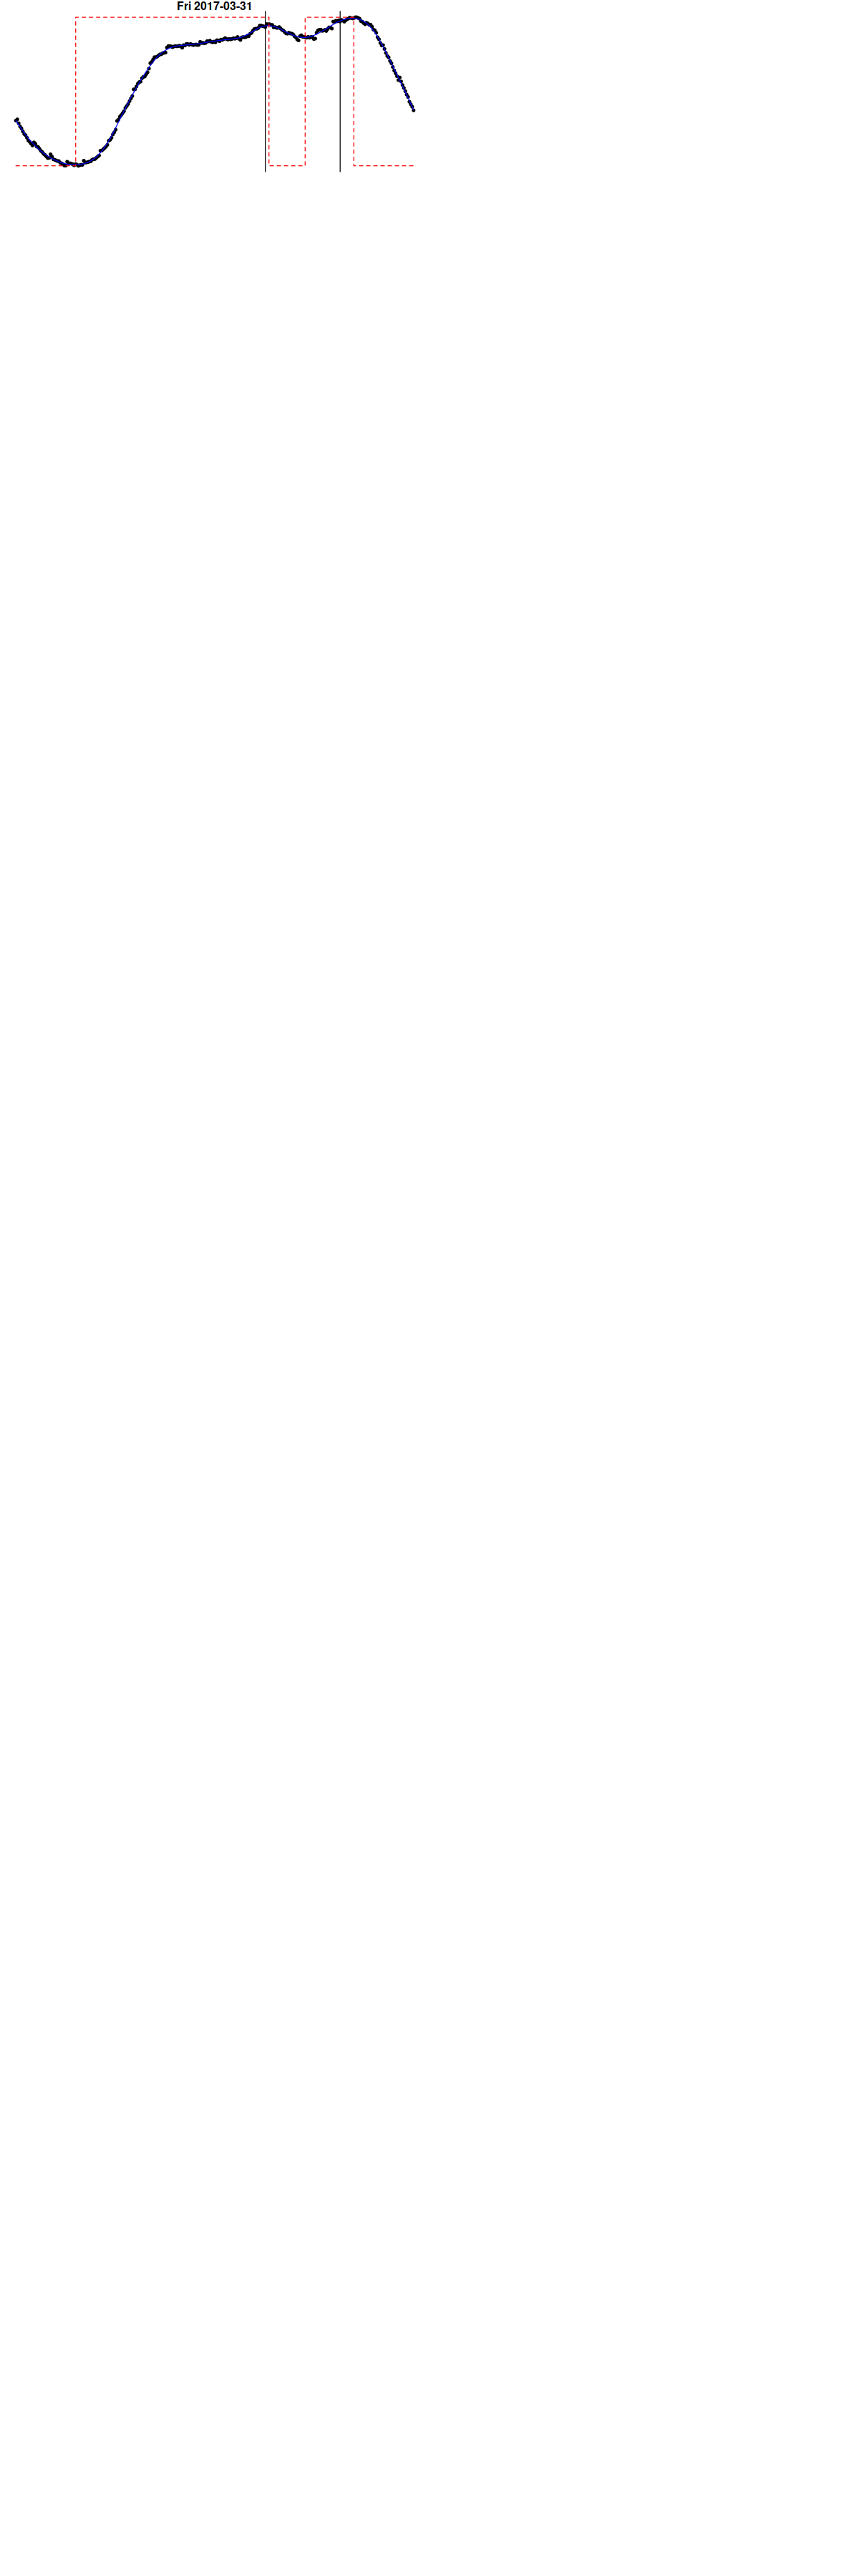

In [426]:
times.5 <- format(seq(from = as.POSIXct("2018-08-02 00:00:00", tz="UTC"), to=as.POSIXct("2018-08-02 23:59:59", tz="UTC"), by="5 min"), "%H:%M")
options(repr.plot.width=10, repr.plot.height=30)
par(mfrow=c(15,2),mar=c(0,0,1,0),bty="n",xaxt="n",yaxt="n")
for(d in seq(from=as.Date("2017-03-01"), to=as.Date("2017-03-31"), by=1)) {
    if(!d %in% unique(as.Date(index(lon2.2016.2017)))) {
        plot(1, pch="")
    } else {
        with(lon2.2016.2017[as.character(as.Date(d)), ], {
            bw <- as.vector(Bandwidth)
            ts.spline <- smooth.spline(bw, df=24)
            plot(bw, main=paste(weekdays(d), as.Date(d)), pch=20)
            abline(v=which(times.5 == "15:00"))
            abline(v=which(times.5 == "19:30"))
            lines(ts.spline, col="blue", type="l")
            par(new=T)
            plot(sign(diff(ts.spline$y)), type="s", lty=2, col="red")
        })
    }
}

In [427]:
#tapply(lon2.2016.2017$Bandwidth, as.Date(index(lon2.2016.2017), tz="Europe/London"), function(x) {
#  message(head(index(x), 1))  
#})

In [428]:
# 5 minute data bandwidth features
#m <- do.call(rbind, tapply(lon2.2016.2017$Bandwidth, as.Date(index(lon2.2016.2017)), phase_summary))
commute.summary.stats <- function(x) {
    summary.stats(x[which(times.5 == "15:00"):which(times.5 == "19:30")])
}

indexTZ(lon2.2016.2017) <- "Europe/London"
bandwidth.features.5 <- do.call(rbind, tapply(lon2.2016.2017$Bandwidth, as.Date(index(lon2.2016.2017), tz="Europe/London"), function(x) {
    c(do.call(c, phase_summary(as.vector(x))), summary.stats(as.vector(x)), evcom=commute.summary.stats(as.vector(x)), evcom.diff=commute.summary.stats(as.vector(x)))
}))

Warning message in (function (..., deparse.level = 1) :
“number of columns of result is not a multiple of vector length (arg 870)”

In [429]:
head(bandwidth.features.5)

changepoint1 changepoint2 changepoint3 changepoint4 value1      
2016-01-01 70            NA           NA          250          142094581805
2016-01-02 67           199          210          233          148035334122
2016-01-03 69            NA           NA          241          154515455881
2016-01-04 58           197          216          249          148035131315
2016-01-05 56           202          222          249          159042717644
2016-01-06 55           202          218          249          155683624698
           value2       value3       value4       Min.         1st Qu.      ⋯
2016-01-01           NA           NA 449523344203 143770736384 200902400233 ⋯
2016-01-02 443893943836 435825414109 461636251086 148743229845 209086427737 ⋯
2016-01-03           NA           NA 483353078032 154824161264 217611926815 ⋯
2016-01-04 464677045201 452847569505 487948966186 150665479496 232688429571 ⋯
2016-01-05 482618200642 463088495768 499520218623 157724785859 233081266233 ⋯
2016-01-06 475163929776 470021276110 495608913792 156881748548 234629251117 ⋯
           evcom.kurtosis evcom.diff.Min. evcom.diff.1st Qu. evcom.diff.Median
2016-01-01 1.924710       401907916456    416933225843       427762129779     
2016-01-02 4.027086       412032007755    440052498462       445847497414     
2016-01-03 1.924700       438120266851    452433589801       469669191285     
2016-01-04 2.427025       449556636553    457340399215       461028976060     
2016-01-05 3.232833       448954882613    466512692027       469333429395     
2016-01-06 2.268679       461302506363    468012970073       472853984472     
           evcom.diff.Mean evcom.diff.3rd Qu. evcom.diff.Max. evcom.diff.sd
2016-01-01 425759829779    438376637395       441250893916    11753115016  
2016-01-02 445522915809    451147855817       462726229125    11322320919  
2016-01-03 463471502051    473054482776       486085864668    13871394003  
2016-01-04 460227649847    464268986840       467029149136     4783434325  
2016-01-05 470120477181    475976936402       483035505031     8105289455  
2016-01-06 471519223759    475563635498       477707353696     5019458071  
           evcom.diff.skewness evcom.diff.kurtosis
2016-01-01 -0.2573730          1.924710           
2016-01-02 -0.7879335          4.027086           
2016-01-03 -0.4288955          1.924700           
2016-01-04 -0.6249541          2.427025           
2016-01-05 -0.5084312          3.232833           
2016-01-06 -0.7349046          2.268679

this is the weekly average (x=2*52) of the time of day that the evening peak in traffic occurs (y=time since midnight in 5 min intervals) - summer = later, winter = earlier (perhaps inline with sunset?)

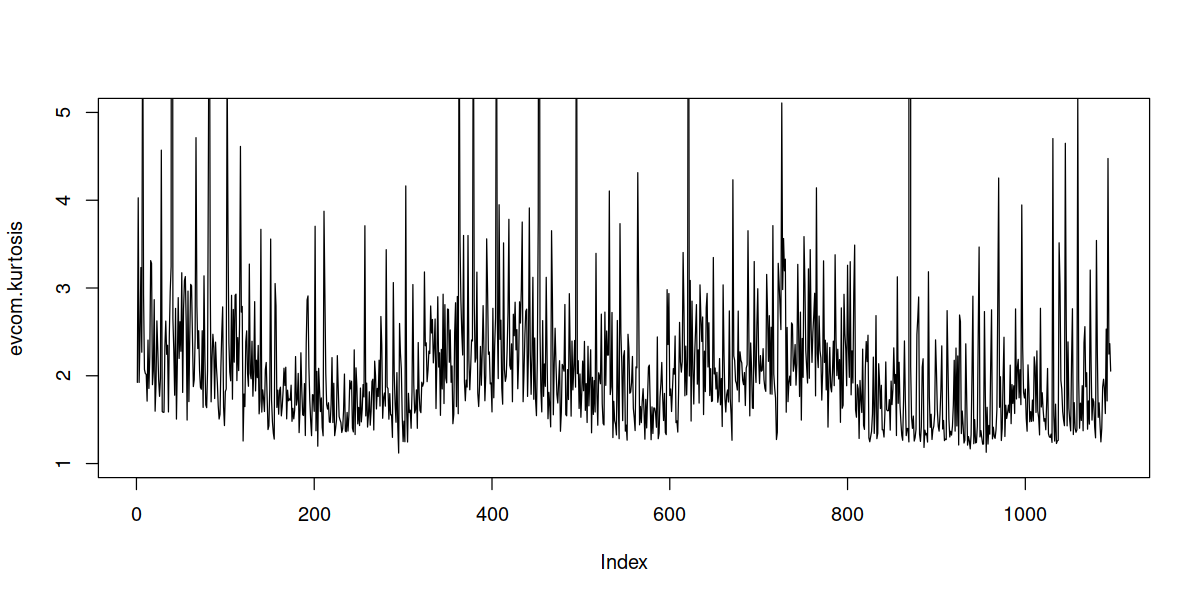

In [430]:
options(repr.plot.width=10, repr.plot.height=5)
with(as.data.frame(bandwidth.features.5), plot(evcom.kurtosis, type="l", ylim=c(1, 5)))

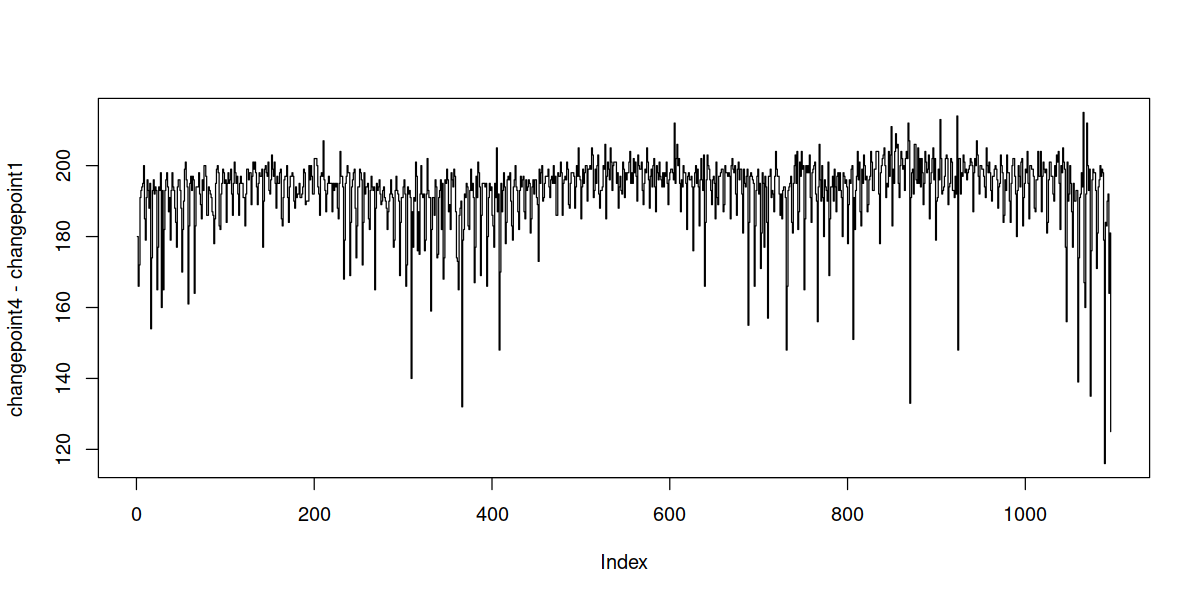

In [431]:
options(repr.plot.width=10, repr.plot.height=5)
# summer = longer days overall (low to high)
with(as.data.frame(bandwidth.features.5), plot(changepoint4 - changepoint1, type="s"))

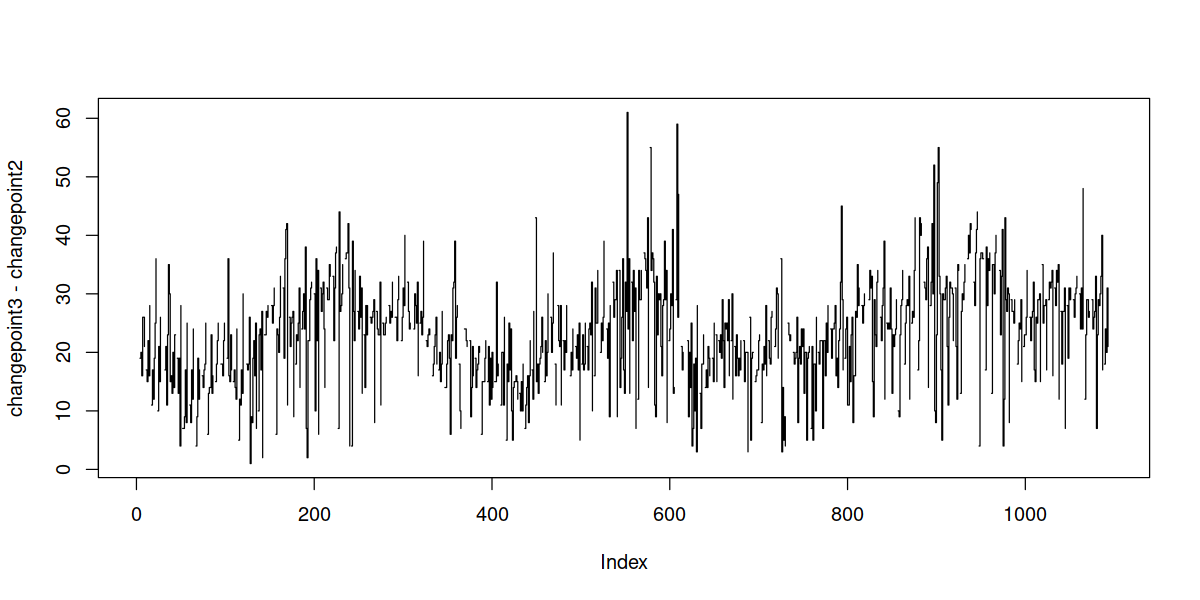

In [432]:
# summer = longer days (low to high)
with(as.data.frame(bandwidth.features.5), plot(changepoint3 - changepoint2, type="s"))

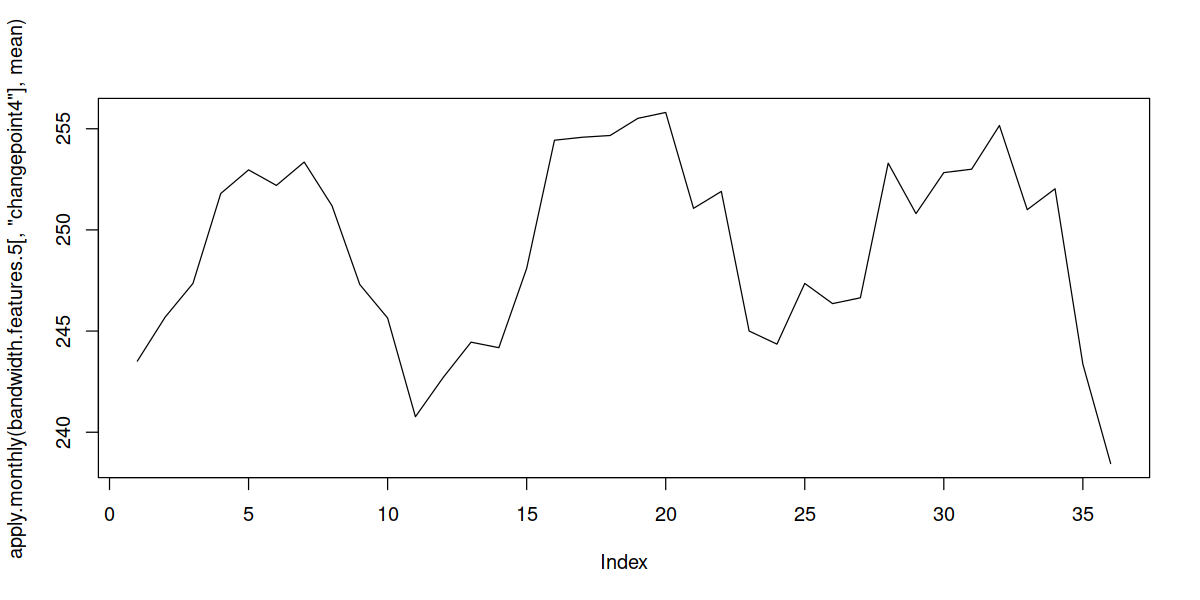

In [433]:
options(repr.plot.width=10, repr.plot.height=5)
plot(apply.monthly(bandwidth.features.5[,"changepoint4"], mean), type="l")

In [434]:
# approx monthly daylight hours
daylight <- c(8,9,11,13,15,16,16.5,16,14,11,10,8)

In [435]:
cp1 <- bandwidth.features.5[,"changepoint1"]
cp2 <- bandwidth.features.5[,"changepoint2"]
cp3 <- bandwidth.features.5[,"changepoint3"]
cp4 <- bandwidth.features.5[,"changepoint4"]

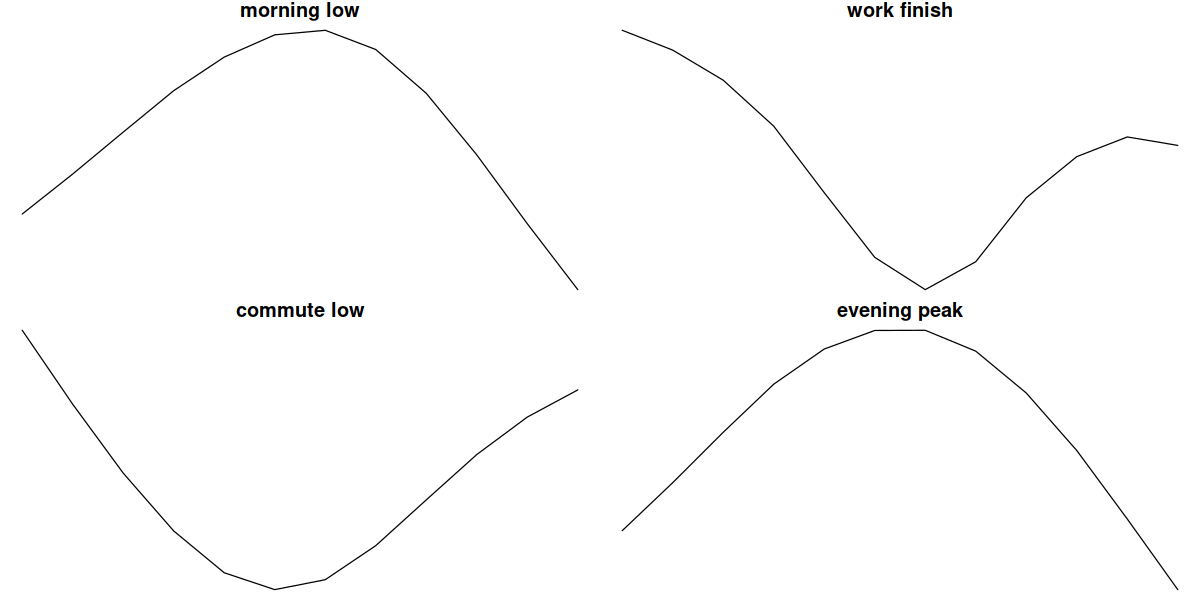

In [436]:
options(repr.plot.width=10, repr.plot.height=5)

cross_section <- function(x) {
    m <- apply.monthly(x, function(x) mean(x, na.rm=T))
    m <- data.frame(x=as.vector(m), month=1:12)
    smooth.spline(tapply(m$x, m$month, mean), )$y
}

par(mfrow=c(2,2),mar=c(0,0,1,0),bty="n",xaxt="n",yaxt="n")
plot(cross_section(cp1), type="l", main="morning low")
plot(cross_section(cp2), type="l", main="work finish")
plot(cross_section(cp3), type="l", main="commute low")
plot(cross_section(cp4), type="l", main="evening peak")                  

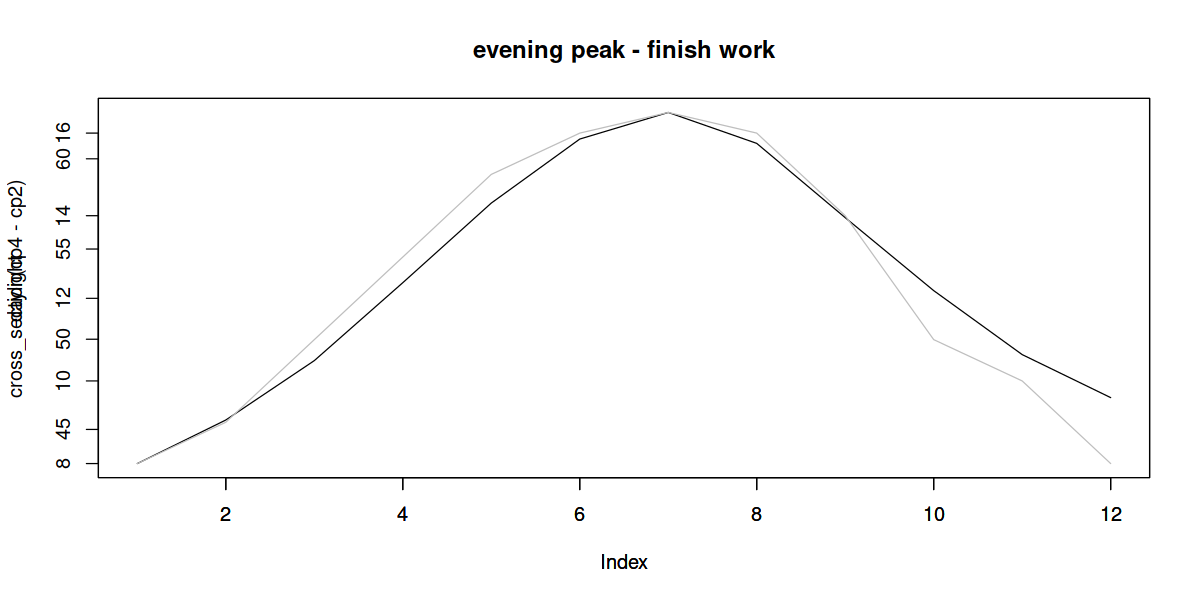

In [437]:
plot(cross_section(cp4-cp2), type="l", main="evening peak - finish work")
par(new=T)
plot(daylight, type="l",col="grey")

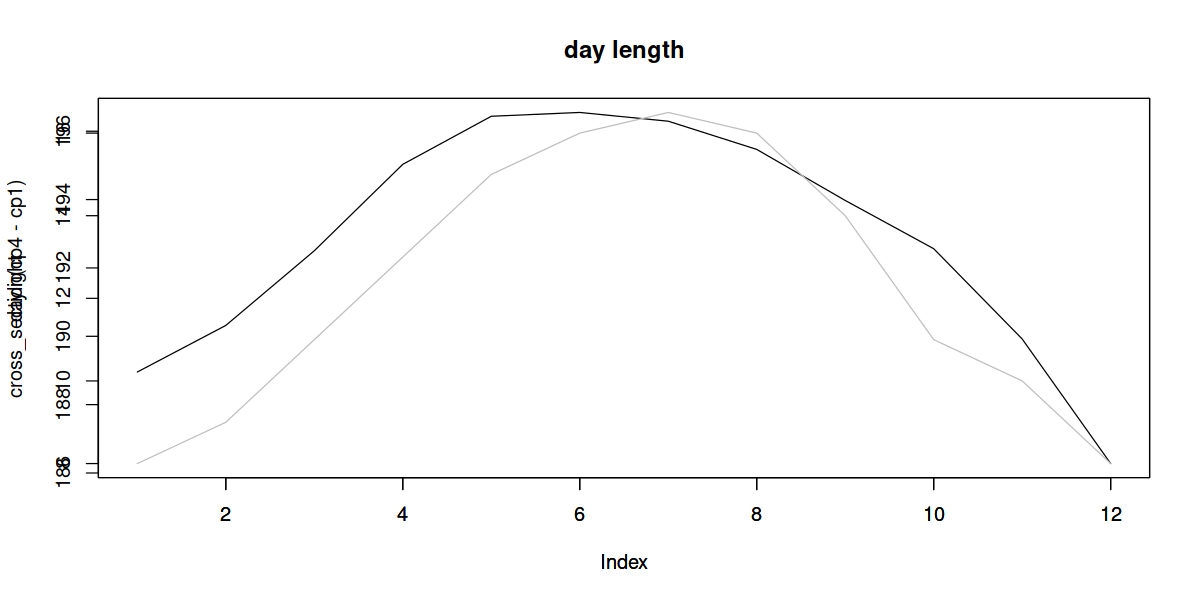

In [438]:
plot(cross_section(cp4-cp1), type="l", main="day length")
par(new=T)
plot(daylight, type="l",col="grey")

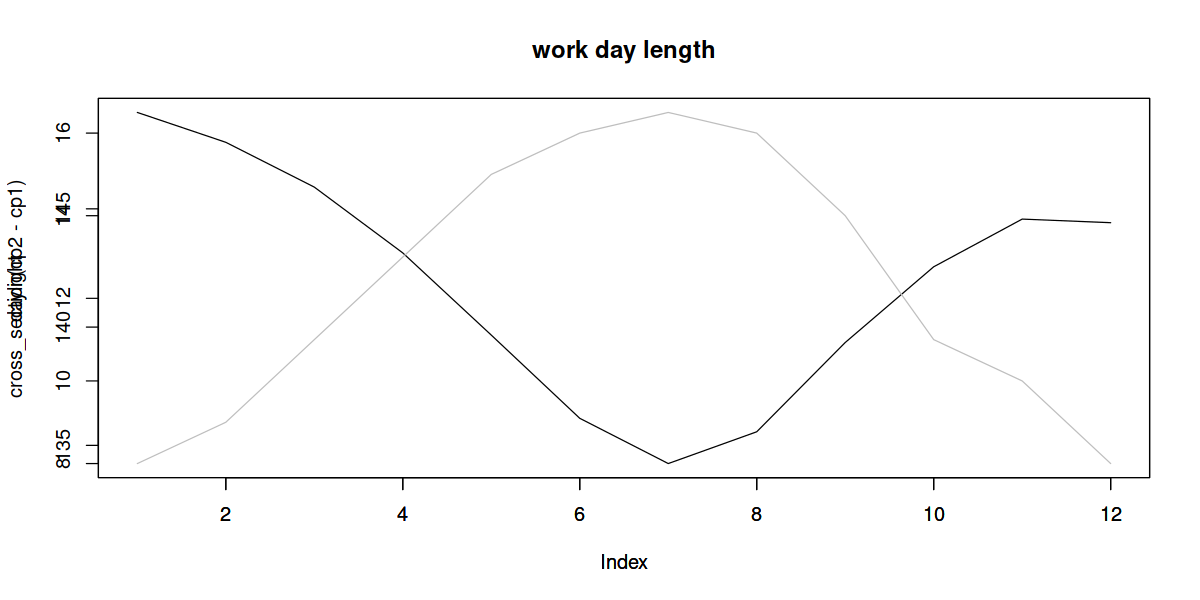

In [439]:
plot(cross_section(cp2-cp1), type="l", main="work day length")
par(new=T)
plot(daylight, type="l",col="grey")

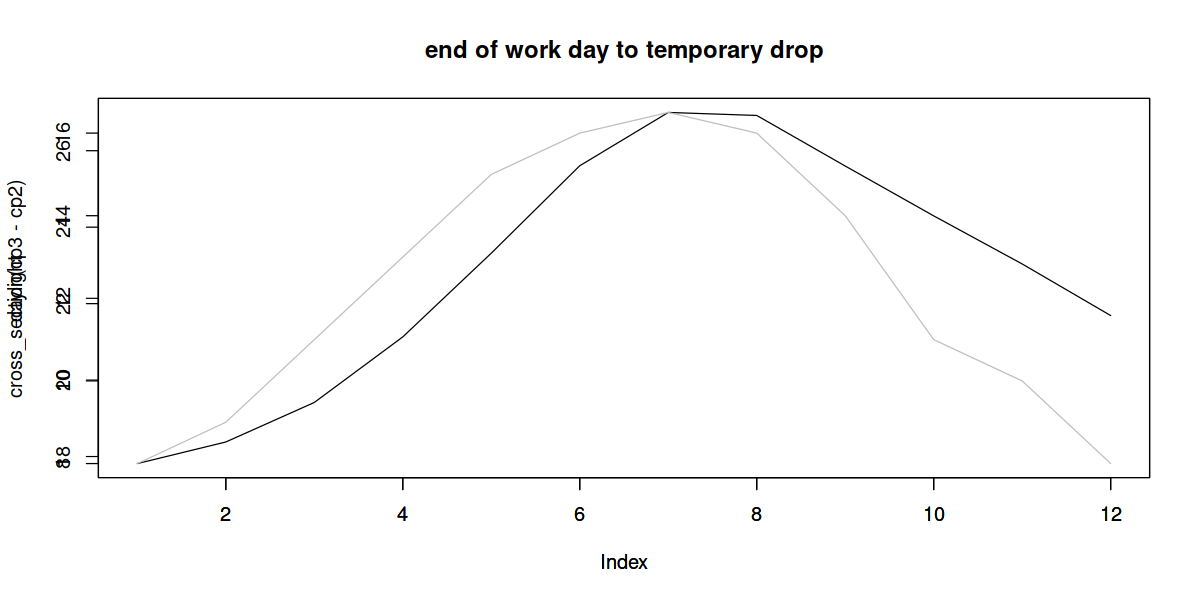

In [440]:
plot(cross_section(cp3-cp2), type="l", main="end of work day to temporary drop")
par(new=T)
plot(daylight, type="l",col="grey")

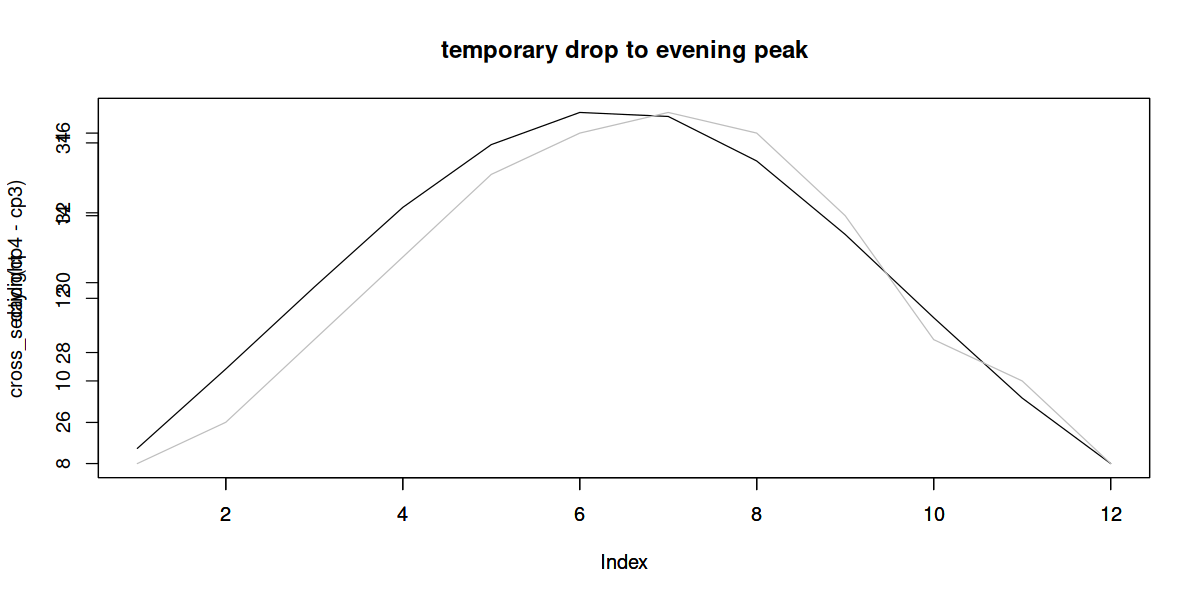

In [441]:
plot(cross_section(cp4-cp3), type="l", main="temporary drop to evening peak")
par(new=T)
plot(daylight, type="l",col="grey")

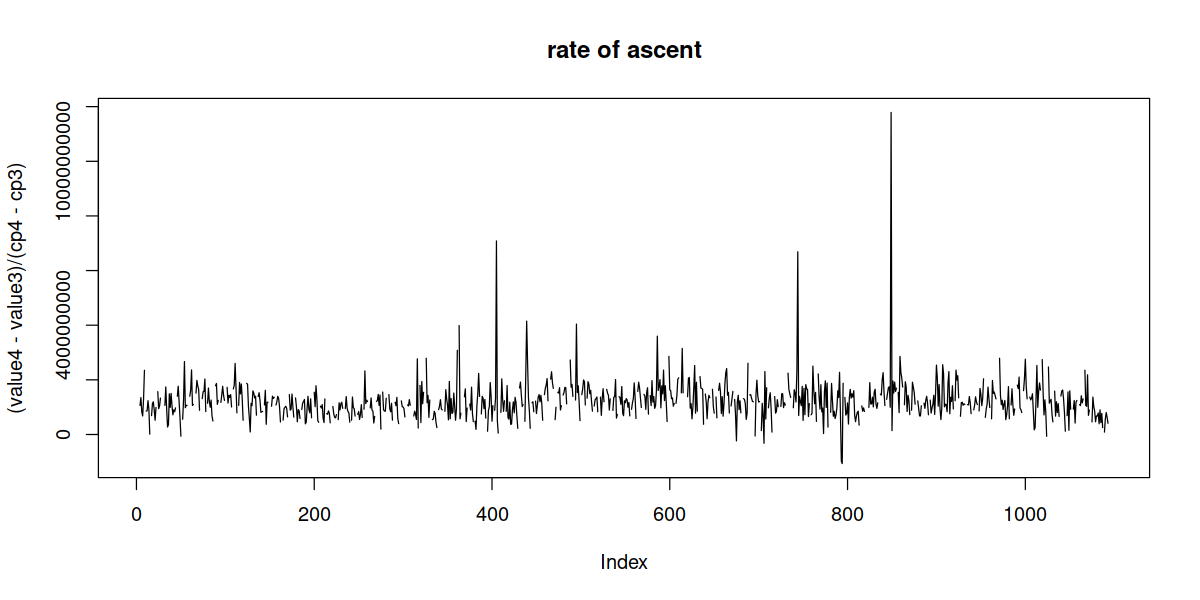

In [442]:
with(data.frame(bandwidth.features.5), plot((value4-value3)/(cp4-cp3), type="l", main="rate of ascent"))

In [443]:
write.csv(bandwidth.features.5, "bandwidth_features_london.csv", quote=F)

# now the same for traffic (counts)

In [444]:
stopifnot(sum(abs(diff(table(traffic$interval)))) == 0) # check we have all the intervals.

In [445]:
head(traffic)

date       interval count  speed
1 2016-01-01 1         37.18 62.17
2 2016-01-01 2         45.27 62.50
3 2016-01-01 3         76.64 62.72
4 2016-01-01 4        105.16 62.72
5 2016-01-01 5        119.63 62.51
6 2016-01-01 6        129.62 62.42

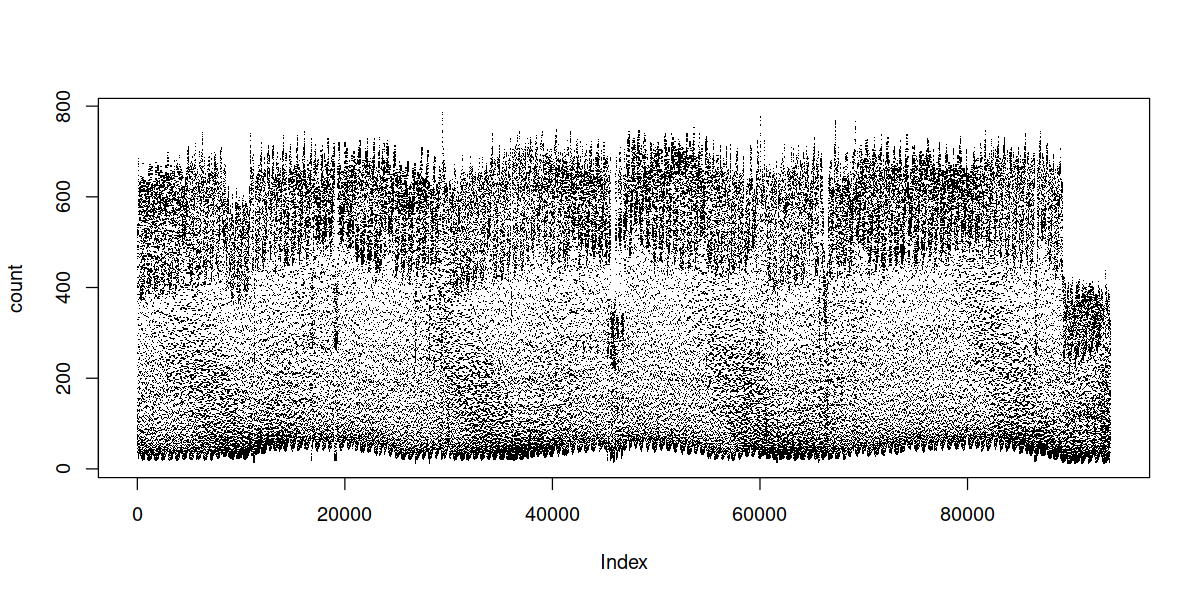

In [446]:
with(traffic, plot(count, pch="."))

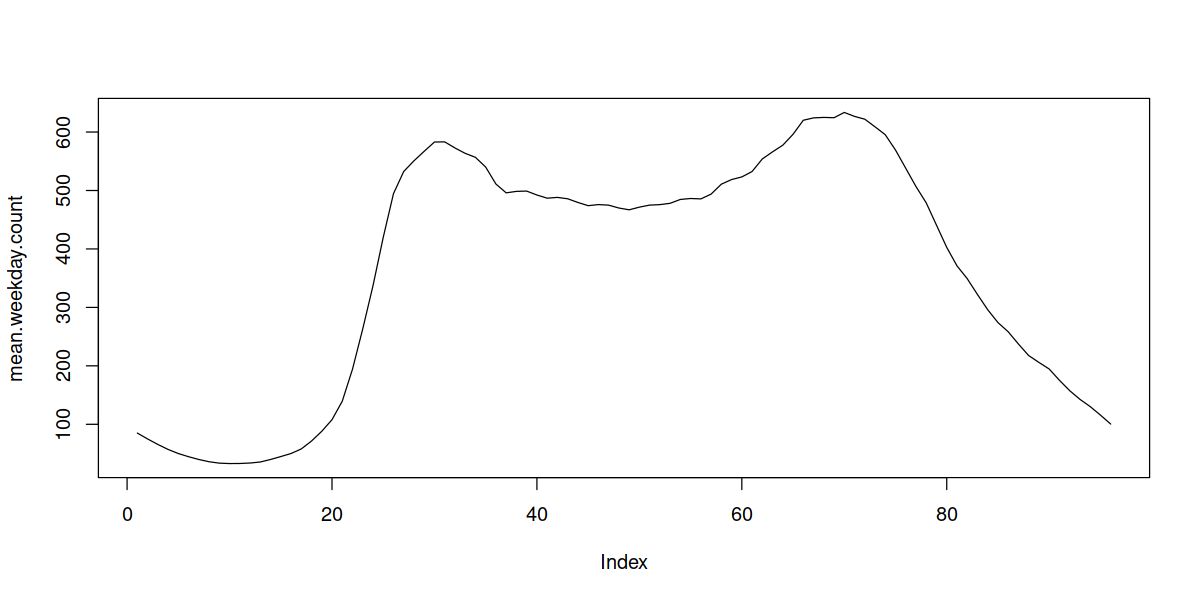

In [447]:
mean.weekday.count <- as.vector(with(traffic[!is.weekend(traffic$date), ], tapply(count, interval, mean)))
plot(mean.weekday.count, type="l")

In [448]:
count_phase_summary <- function(day, df=19) {
    a <- NA
    b <- NA
    c <- NA
    d <- NA
    ts.spline <- smooth.spline(day, df=df)$y
    changepoints <- which(c(NA, diff(sign(diff(ts.spline)))) != 0)
    N <- length(changepoints)
    if(N >= 2) {
        # morning dip is always the first one
        a <- changepoints[1]
        if(N >= 4) {
            # morning peak
            b <- changepoints[2]
            # afternoon drop (min between morning and evening peak)
            min.cp <- which.min(ts.spline[changepoints[3:(N-1)]])
            c <- changepoints[2+min.cp]
        }
        # evening peak is always the last one
        d <- changepoints[N]
    }
    list(changepoint=c(a, b, c, d), value=ts.spline[c(a, b, c, d)])
}

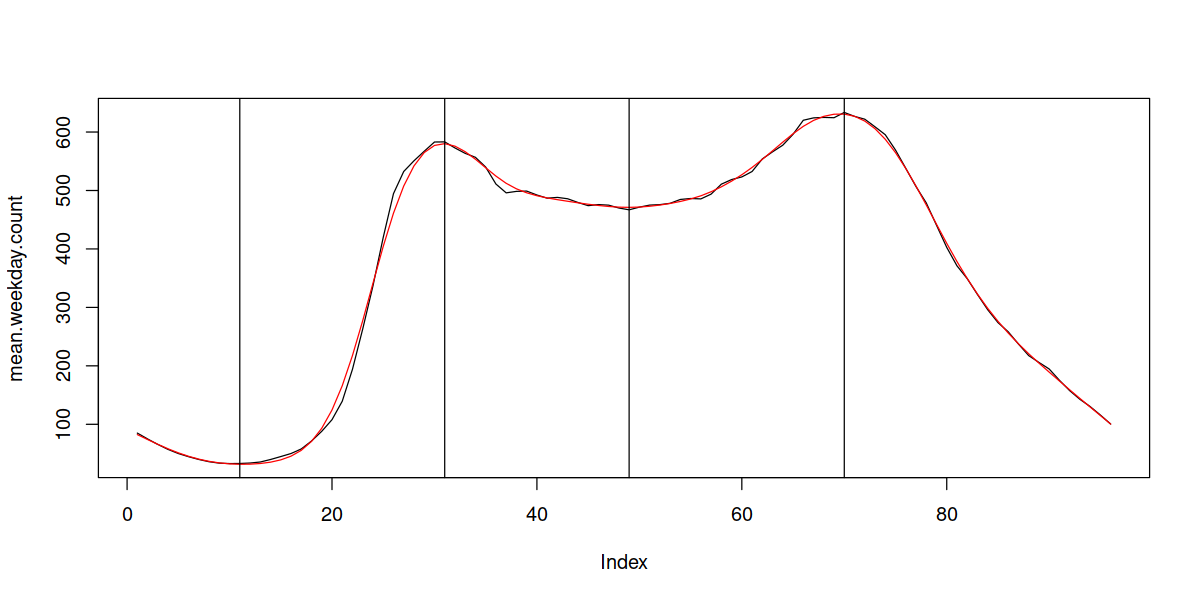

In [449]:
options(repr.plot.width=10, repr.plot.height=5)
cp <- count_phase_summary(mean.weekday.count)
plot(mean.weekday.count, type="l")
lines(smooth.spline(mean.weekday.count, df=19)$y, col="red")
abline(v=cp$changepoint)

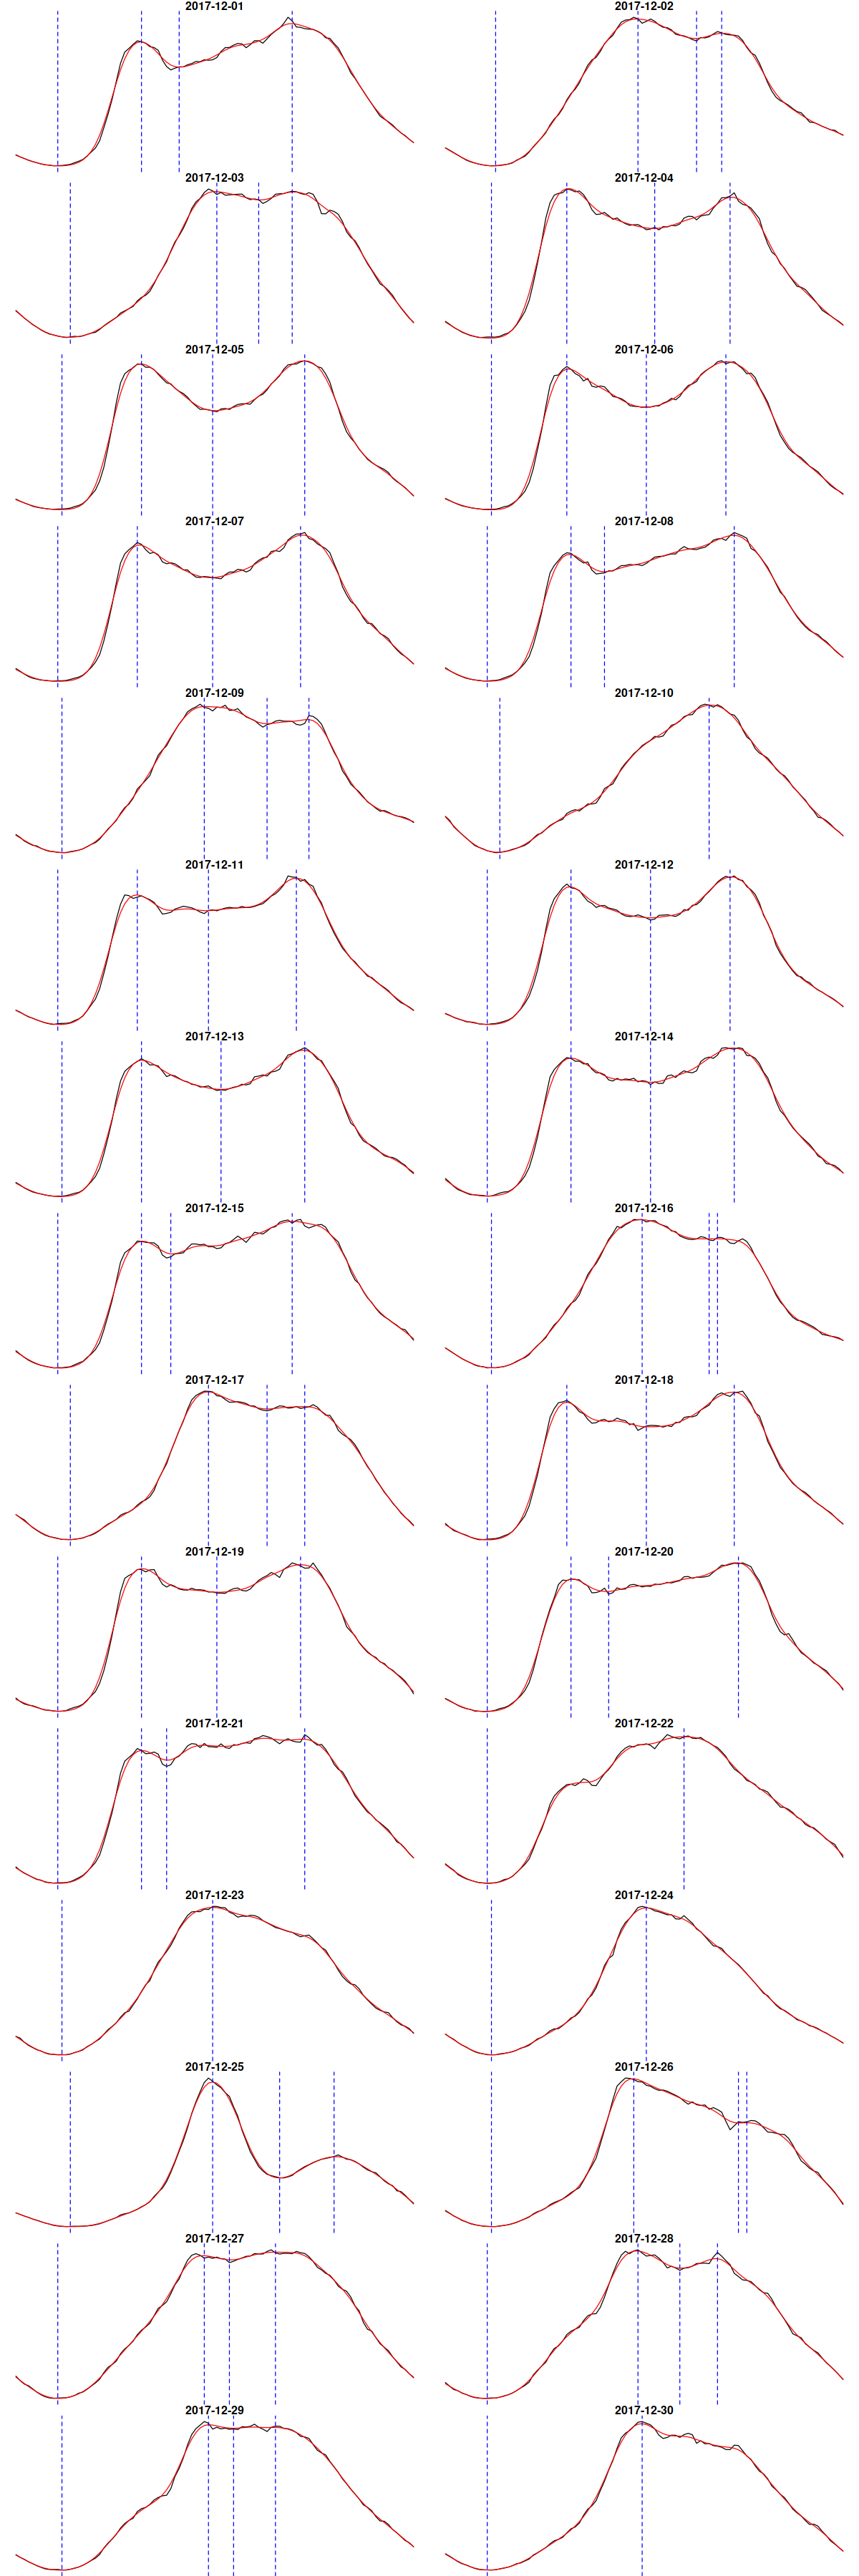

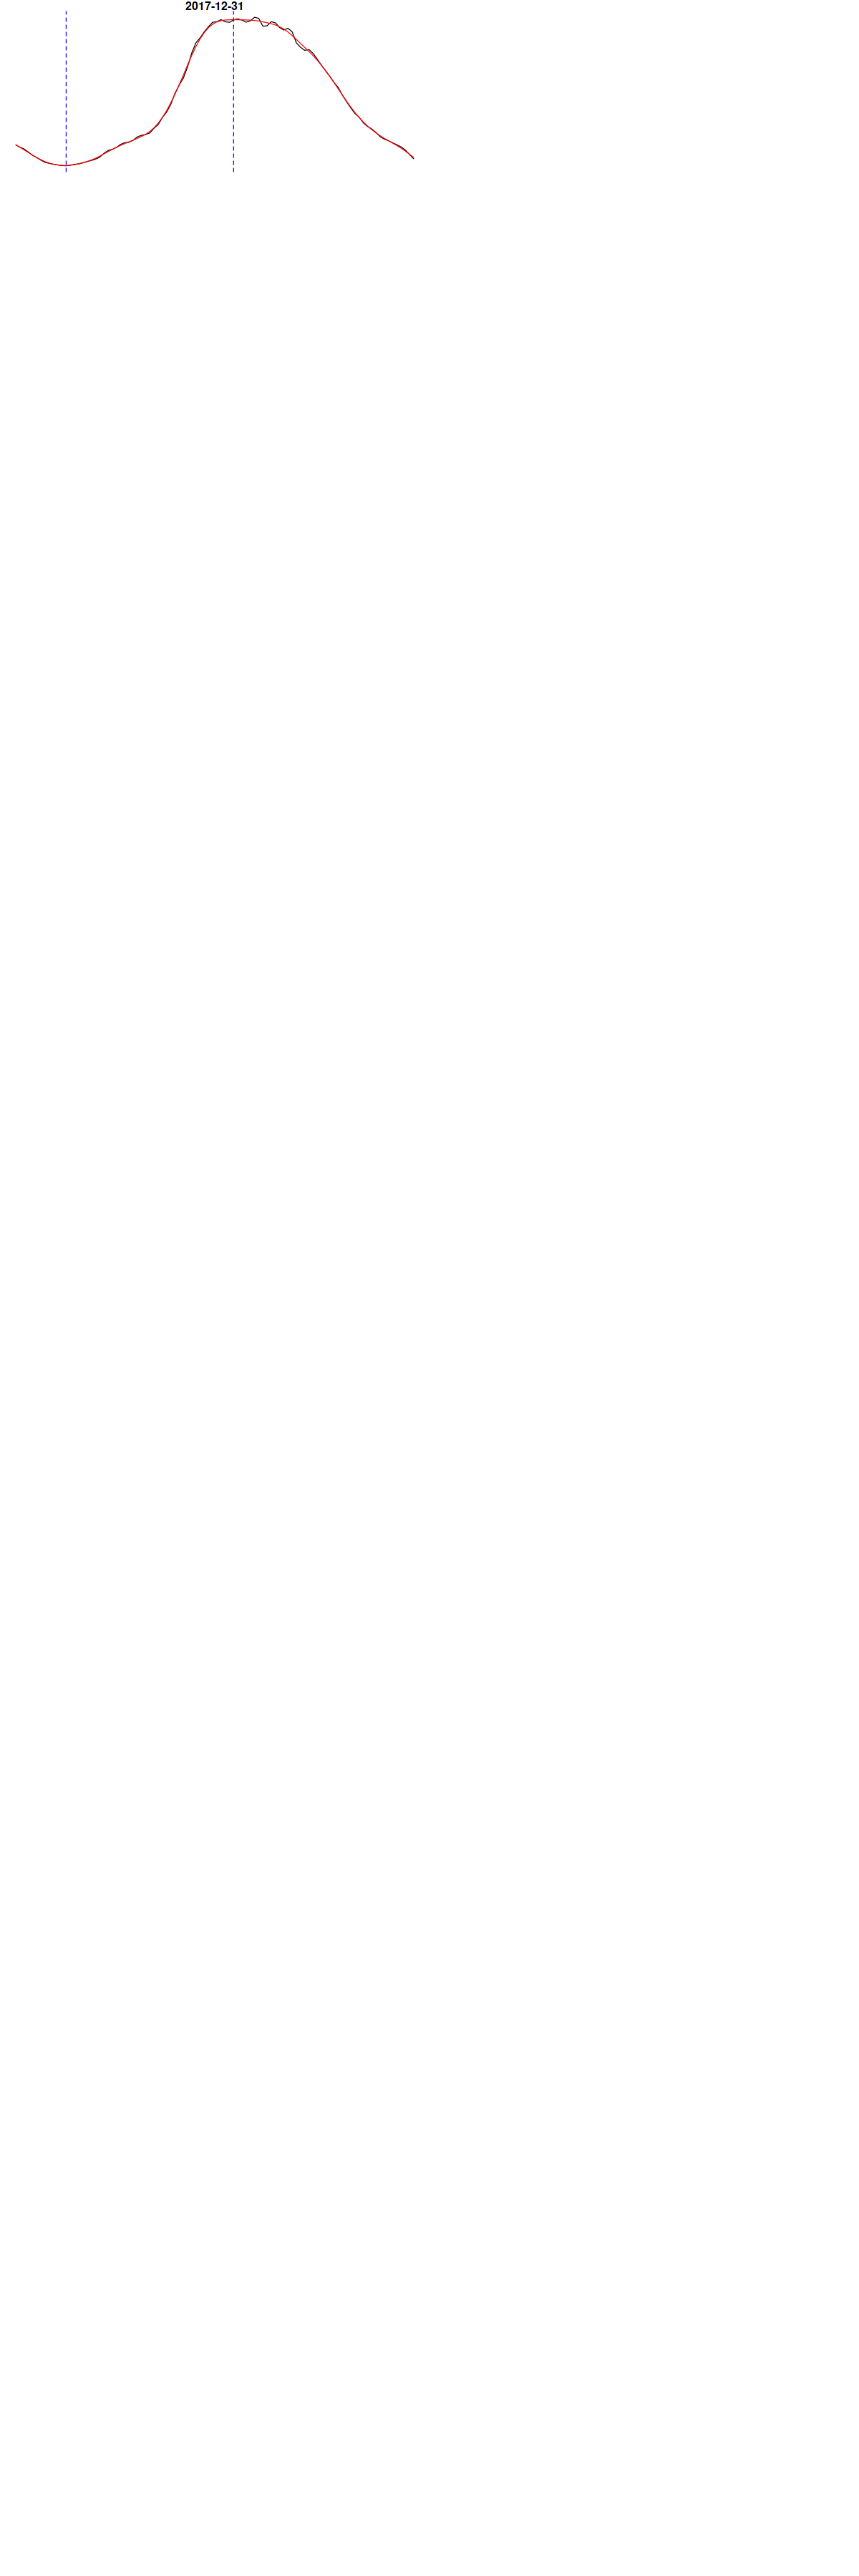

In [450]:
options(repr.plot.width=10, repr.plot.height=30)
par(mfrow=c(15,2),mar=c(0,0,1,0),bty="n",xaxt="n",yaxt="n")
for(d in seq(from=as.Date("2017-12-01"), to=as.Date("2017-12-31"), by=1)) {
    if(!d %in% unique(traffic$date)) {
        plot(1, pch="")
    } else {
        count.day <- as.vector(traffic[traffic$date == d, ]$count)
        cp <- count_phase_summary(count.day)
        plot(count.day, type="l", main=as.Date(d))
        lines(smooth.spline(count.day, df=19)$y, col="red")
        abline(v=cp$changepoint, col="blue", lty=2)
    }
}

# speed

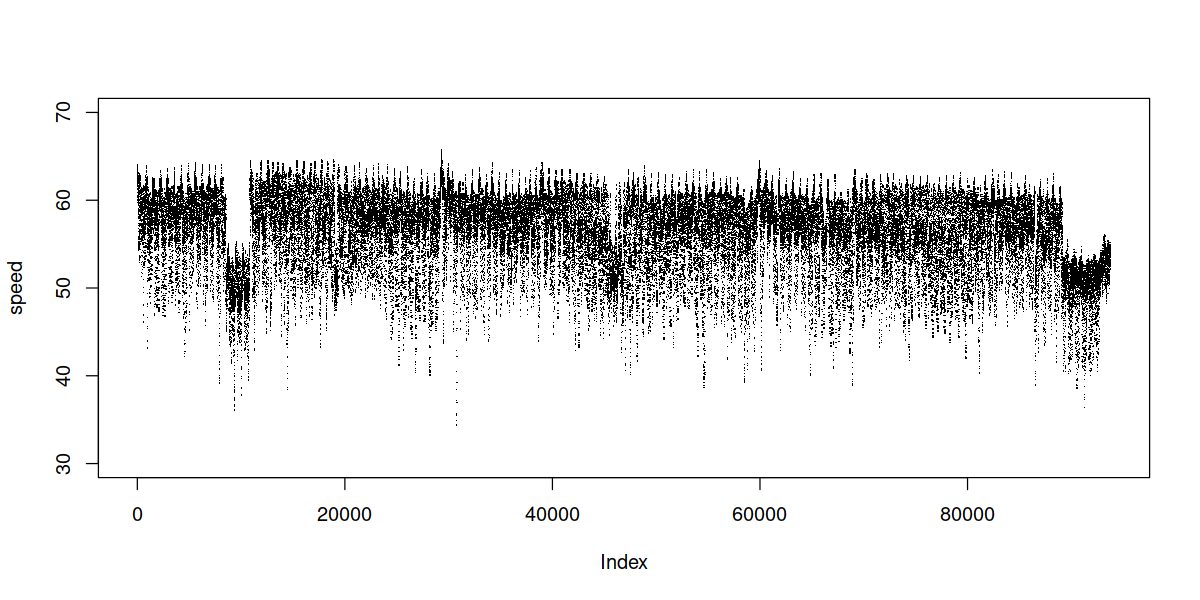

In [451]:
options(repr.plot.width=10, repr.plot.height=5)
with(traffic, plot(speed, pch=".", ylim=c(30, 70)))

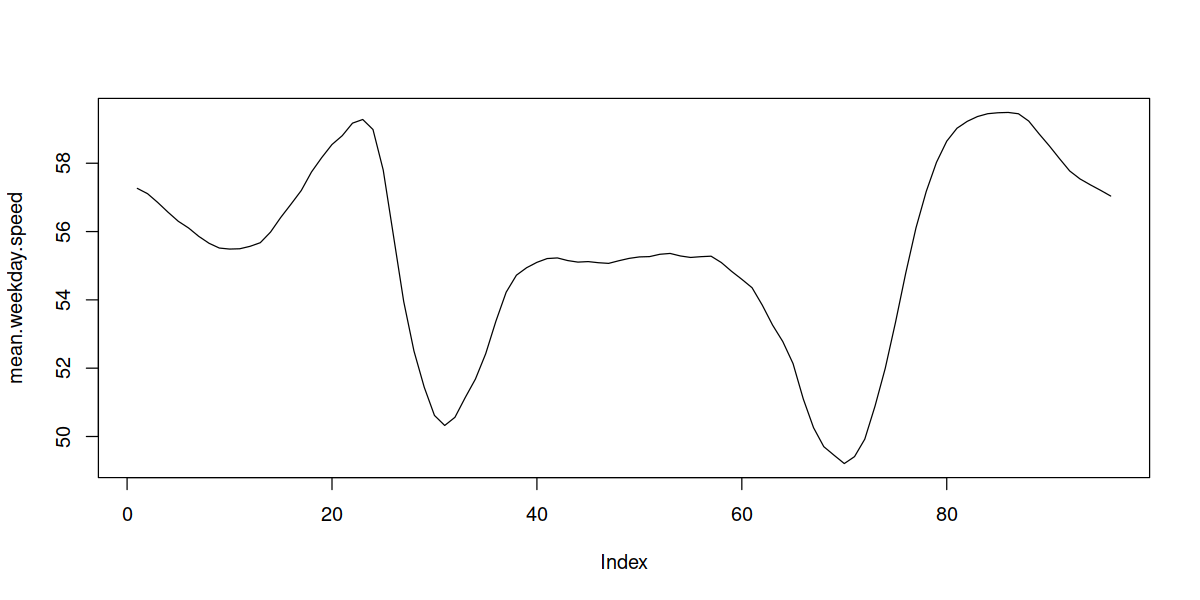

In [452]:
mean.weekday.speed <- as.vector(with(traffic[!is.weekend(traffic$date), ], tapply(speed, interval, mean)))
plot(mean.weekday.speed, type="l")

speed series is quite complicated - need to make use of peaks and troughs in addition to changepoints.

In [453]:
speed_phase_summary <- function(day, df=12) {
    a <- NA
    b <- NA
    c <- NA
    d <- NA
    e <- NA
    ts.spline <- smooth.spline(day, df=df)$y
    #ts.spline <- head(ts.spline, -4) # cut off last hour.
    changepoints <- which(c(NA, diff(sign(diff(ts.spline)))) != 0)
    N <- length(changepoints)
    if(N >= 2) {
        cp.sign <- sign(diff(ts.spline[changepoints]))
        cp.sign <- c(-1*cp.sign[1], cp.sign) # first one is -second.
        peaks <- changepoints[cp.sign > 0]
        troughs <- changepoints[cp.sign < 0]
        # morning dip is always the first one
        a <- troughs[1]
        # evening peak is always the last one
        e <- peaks[length(peaks)]
        if(N >= 4) {
            # morning peak (before rush hour)
            if(a < peaks[1]) {
                b <- peaks[1]
            } else {
                b <- peaks[2]
            }
            # morning rush hour
            if(b < troughs[2]) {
                c <- troughs[2]
            } else {
                c <- troughs[3]
            }
            if(N >= 5) {
                if(e > troughs[length(troughs)]) {
                    d <- troughs[length(troughs)]
                } else {
                    d <- troughs[length(troughs) - 1]
                }
            }
        }
        list(changepoint=c(a, b, c, d, e), value=ts.spline[c(a, b, c, d, e)])
    } else {
        list(changepoint=rep(NA, 5), value=rep(NA, 5)) 
    }
}

speed data is more volatile - needs more smoothing (df=12)

$changepoint
[1]  9 20 32 69 86

$value
[1] 55.79237 57.99872 52.03328 50.42988 59.40820



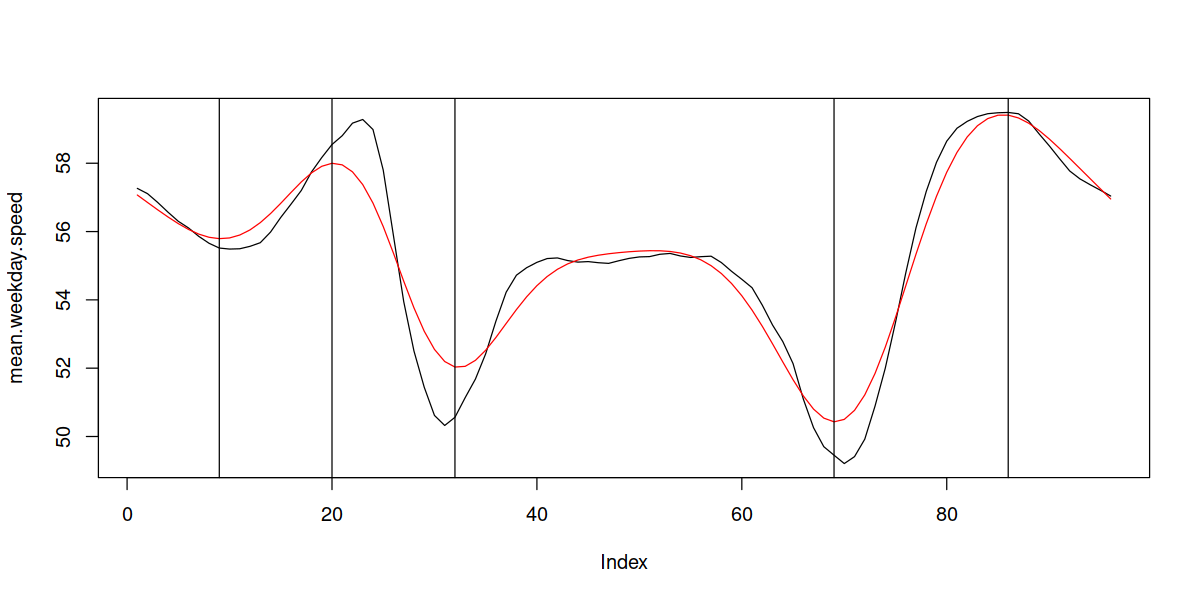

In [454]:
options(repr.plot.width=10, repr.plot.height=5)
cp <- speed_phase_summary(mean.weekday.speed)
plot(mean.weekday.speed, type="l")
lines(smooth.spline(mean.weekday.speed, df=12)$y, col="red")
abline(v=cp$changepoint)
print(cp)

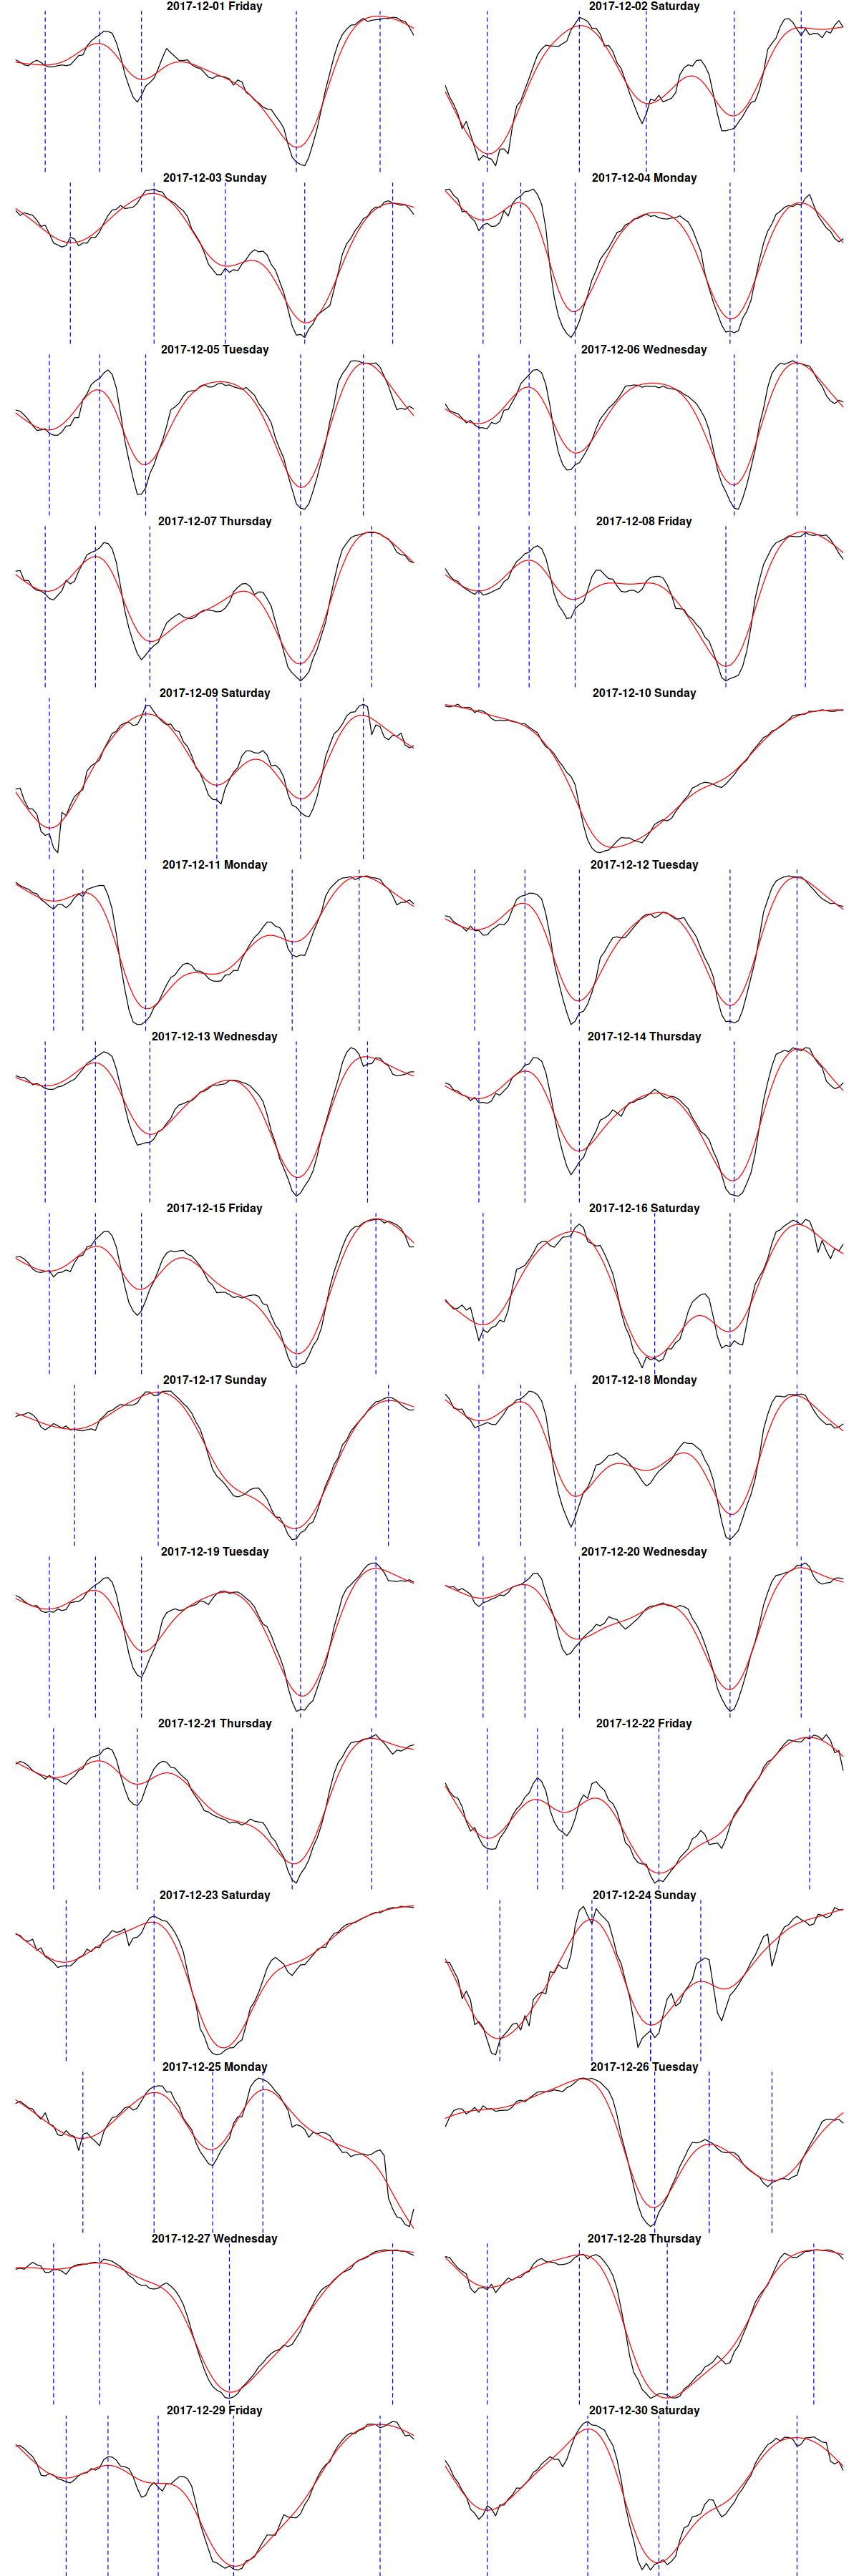

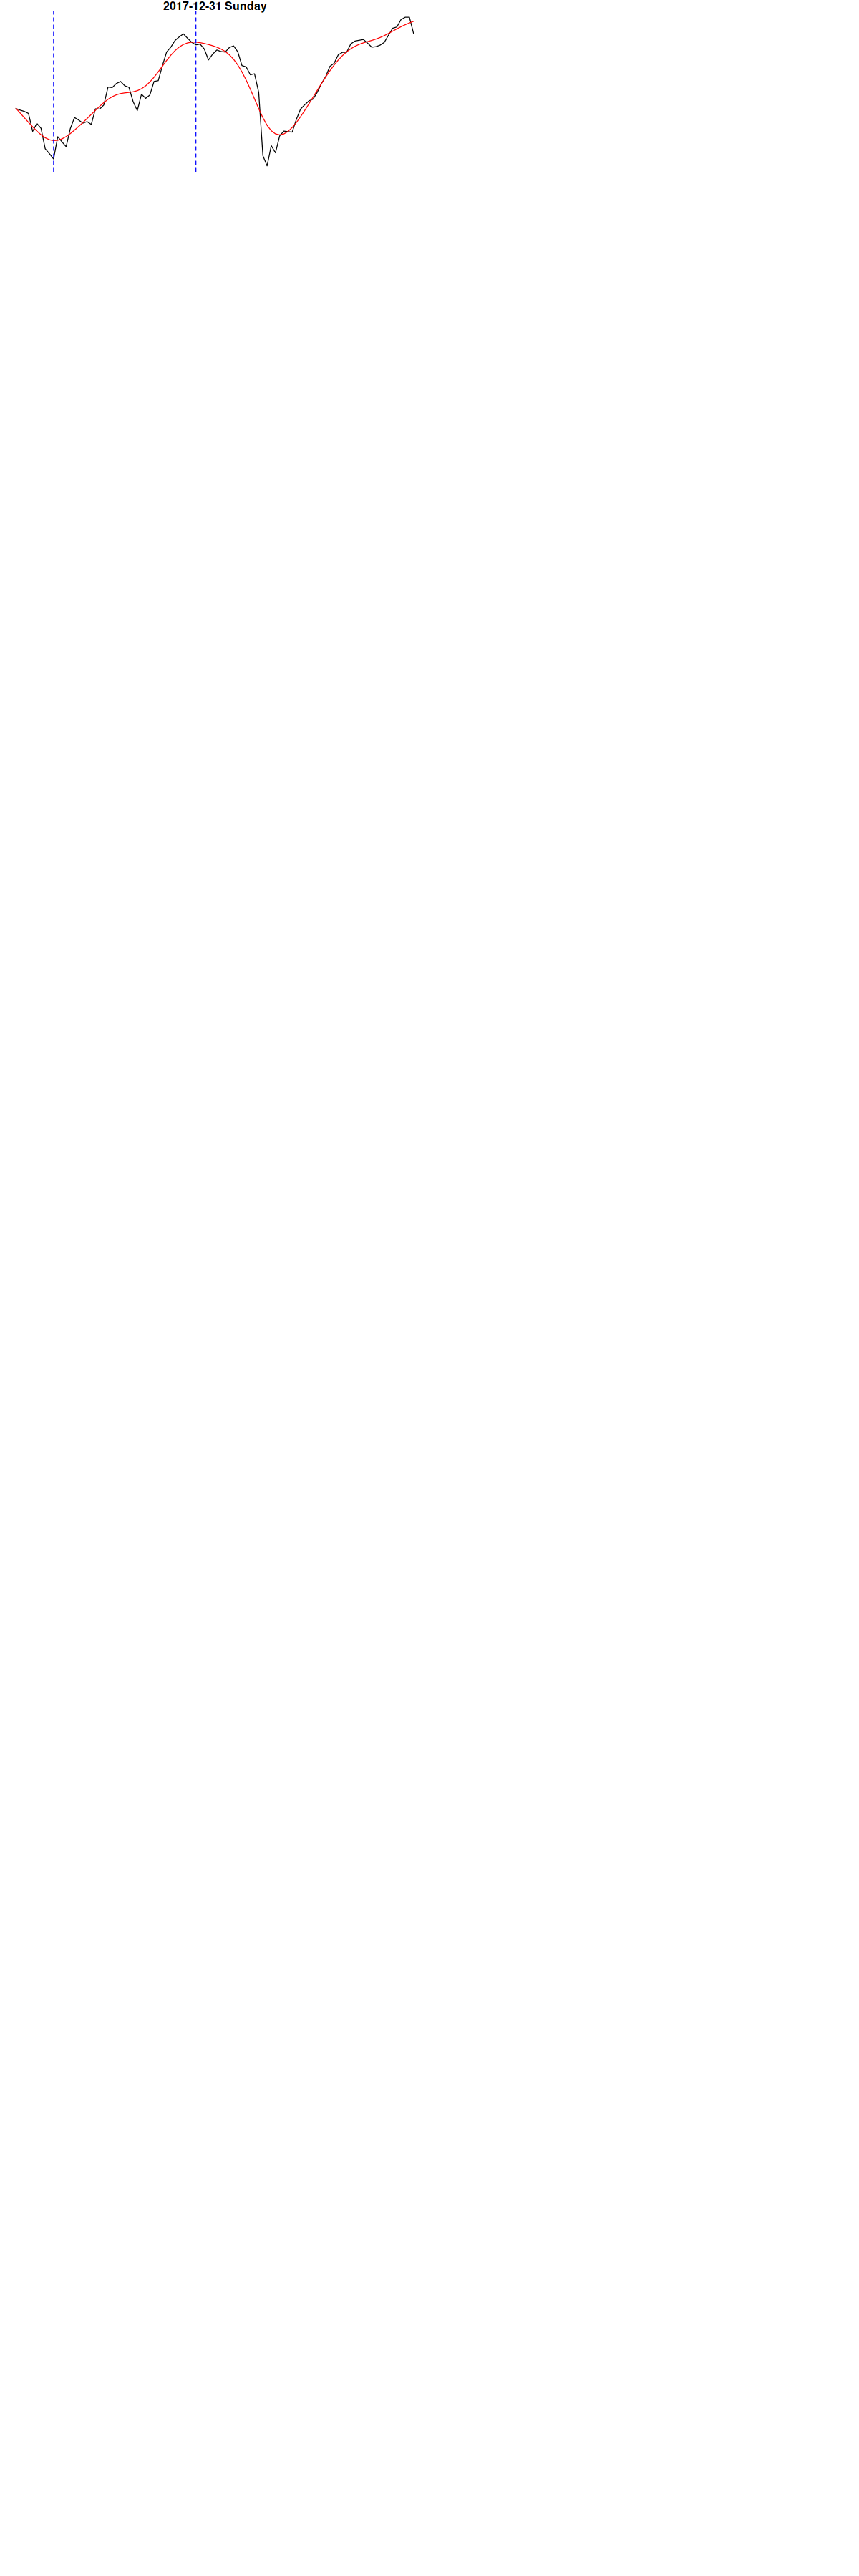

In [455]:
options(repr.plot.width=10, repr.plot.height=30)
par(mfrow=c(15,2),mar=c(0,0,1,0),bty="n",xaxt="n",yaxt="n")
for(d in seq(from=as.Date("2017-12-01"), to=as.Date("2017-12-31"), by=1)) {
    if(!d %in% unique(traffic$date)) {
        plot(1, pch="")
    } else {
        speed.day <- as.vector(traffic[traffic$date == d, ]$speed)
        cp <- speed_phase_summary(speed.day)
        plot(speed.day, type="l", main=paste(as.Date(d), weekdays(as.Date(d))))
        lines(smooth.spline(speed.day, df=12)$y, col="red")
        abline(v=cp$changepoint, col="blue", lty=2)
    }
}

# combine counts + speed

In [456]:
counts <- do.call(rbind, with(traffic, tapply(count, date, function(x) {
    unlist(count_phase_summary(x))
})))

speeds <- do.call(rbind, with(traffic, tapply(speed, date, function(x) {
    unlist(speed_phase_summary(x))
})))

road.combo <- data.frame(speed=speeds, count=counts)

in addition to the changepoint features, add summary stats + mean, sd + 2nd & 3rd moments.

In [457]:
evening.commute.fixed.mph <- data.frame(do.call(rbind, with(traffic, tapply(speed, date, function(x) {
    peak <- x[which(times == "15:00"):which(times == "19:30")]
    summary.stats(peak)
}))))

evening.commute.fixed.diff <- data.frame(do.call(rbind, with(traffic, tapply(speed, date, function(x) {
    peak <- x[which(times == "15:00"):which(times == "19:30")]
    summary.stats(diff(peak))
}))))

whole.day.stats.diff <- data.frame(do.call(rbind, with(traffic, tapply(speed, date, function(x) {
    summary.stats(diff(x))
}))))

whole.day.stats <- data.frame(do.call(rbind, with(traffic, tapply(speed, date, function(x) {
    summary.stats(x)
}))))

road.combo <- cbind(road.combo, evcom.fixed.mph=evening.commute.fixed.mph)
road.combo <- cbind(road.combo, evcom.fixed.diff=evening.commute.fixed.diff)
road.combo <- cbind(road.combo, day.stats=whole.day.stats)
road.combo <- cbind(road.combo, day.stats.diff=whole.day.stats.diff)

head(evening.commute.fixed.diff)

Min.  X1st.Qu. Median Mean       X3rd.Qu. Max. sd        skewness  
2016-01-01 -0.53 -0.2850  0.100  0.02611111 0.2975   0.40 0.3134652 -0.4421806
2016-01-02 -0.68 -0.1075  0.195  0.23444444 0.5075   1.35 0.4896364  0.3819306
2016-01-03 -1.38 -0.4450  0.305  0.12888889 0.6200   1.12 0.7083111 -0.6118998
2016-01-04 -0.72 -0.1075  0.005  0.08277778 0.4850   0.72 0.4055904 -0.2540722
2016-01-05 -1.60 -0.1650  0.040  0.10222222 0.7025   1.44 0.7235091 -0.3597426
2016-01-06 -1.35 -0.3125  0.360  0.11666667 0.6500   1.04 0.6933635 -0.5483063
           kurtosis
2016-01-01 1.689082
2016-01-02 3.019733
2016-01-03 2.348531
2016-01-04 2.400511
2016-01-05 3.138855
2016-01-06 2.227357

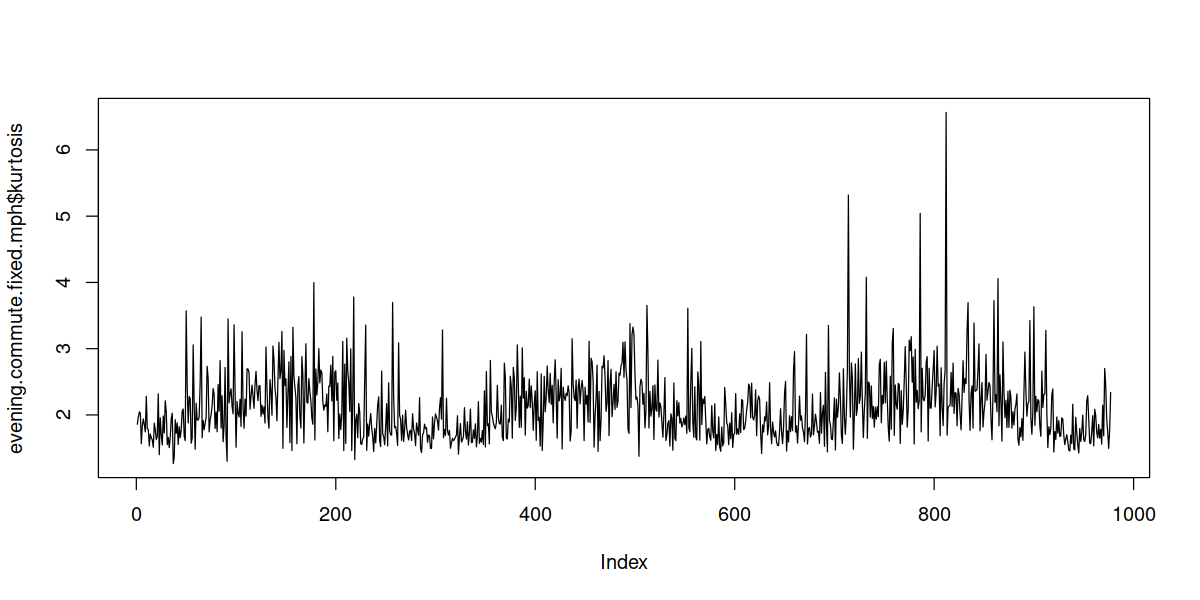

In [458]:
options(repr.plot.width=10, repr.plot.height=5)
plot(evening.commute.fixed.mph$kurtosis, type="l")

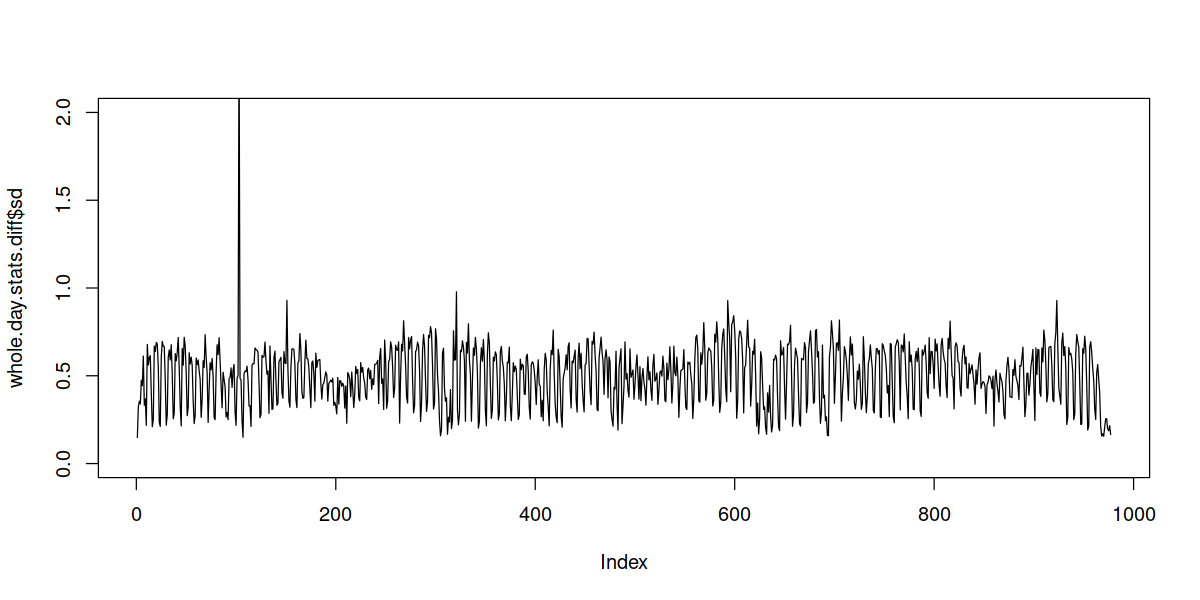

In [459]:
plot(whole.day.stats.diff$sd, type="l", ylim=c(0,2))

In [460]:
head(road.combo)

speed.changepoint1 speed.changepoint2 speed.changepoint3
2016-01-01 21                 39                 68                
2016-01-02 12                 36                 56                
2016-01-03 14                 34                 54                
2016-01-04 12                 20                 30                
2016-01-05  9                 20                 31                
2016-01-06 10                 20                 31                
           speed.changepoint4 speed.changepoint5 speed.value1 speed.value2
2016-01-01 68                 83                 61.96707     63.77429    
2016-01-02 65                 92                 58.74312     62.31922    
2016-01-03 NA                 92                 60.53161     62.85261    
2016-01-04 68                 83                 59.15192     60.19548    
2016-01-05 70                 84                 56.52462     58.62757    
2016-01-06 69                 84                 56.84167     58.33588    
           speed.value3 speed.value4 speed.value5 ⋯ day.stats.kurtosis
2016-01-01 60.54143     60.54143     62.58261     ⋯ 2.982758          
2016-01-02 54.82363     55.04895     62.72029     ⋯ 1.779316          
2016-01-03 53.71352           NA     62.60838     ⋯ 2.591870          
2016-01-04 56.87642     58.30174     61.23006     ⋯ 3.745717          
2016-01-05 53.94578     56.48730     61.13522     ⋯ 3.404194          
2016-01-06 53.89711     56.49921     61.44117     ⋯ 3.298924          
           day.stats.diff.Min. day.stats.diff.X1st.Qu. day.stats.diff.Median
2016-01-01 -0.3864230          -0.07160416             -0.025750464         
2016-01-02 -0.7152680          -0.16585815              0.047535161         
2016-01-03 -0.9236427          -0.16359835              0.058736898         
2016-01-04 -0.9965788          -0.22152663             -0.058271153         
2016-01-05 -1.2606169          -0.20367526             -0.020093942         
2016-01-06 -1.1936249          -0.17903336             -0.008398197         
           day.stats.diff.Mean day.stats.diff.X3rd.Qu. day.stats.diff.Max.
2016-01-01 -0.0073684211       0.06732313              0.2791804          
2016-01-02  0.0123157895       0.23242951              0.5934902          
2016-01-03 -0.0009473684       0.19741796              0.6265545          
2016-01-04 -0.0304210526       0.15126606              0.7899888          
2016-01-05  0.0009473684       0.25931672              1.1692658          
2016-01-06  0.0087368421       0.25266739              1.0417931          
           day.stats.diff.sd day.stats.diff.skewness day.stats.diff.kurtosis
2016-01-01 0.1485087         -0.25478932             3.328902               
2016-01-02 0.3214980         -0.42893122             2.632711               
2016-01-03 0.3547246         -0.73586844             3.474434               
2016-01-04 0.3395244         -0.14224824             3.784296               
2016-01-05 0.4744125          0.03543678             3.656128               
2016-01-06 0.4439887         -0.07427449             3.608673

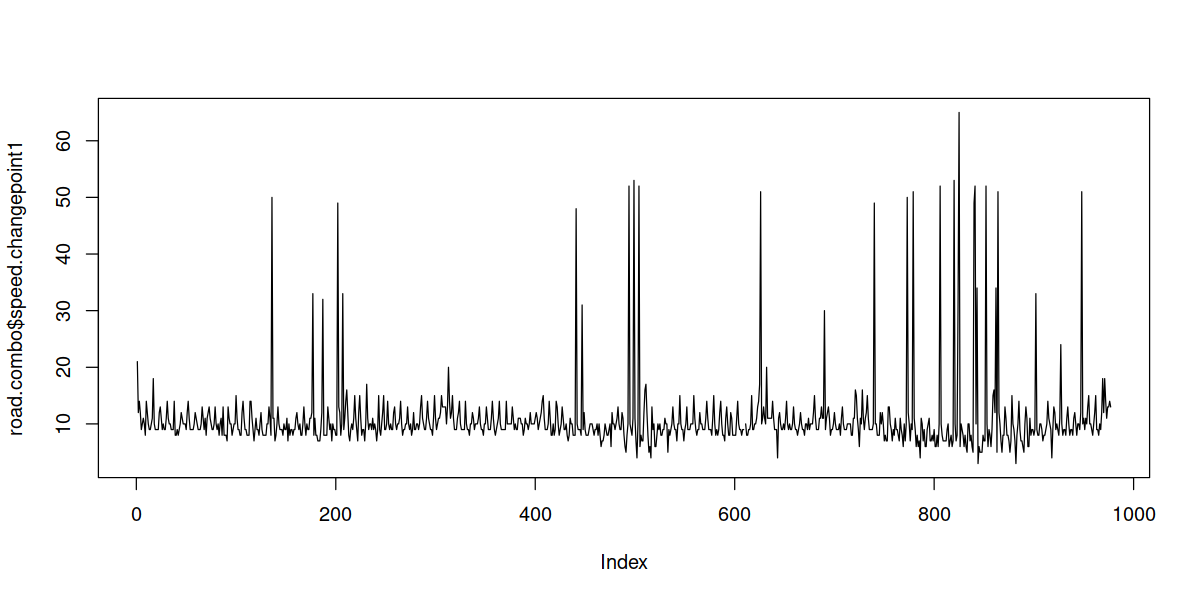

In [461]:
options(repr.plot.width=10, repr.plot.height=5)
plot(road.combo$speed.changepoint1, type="l")

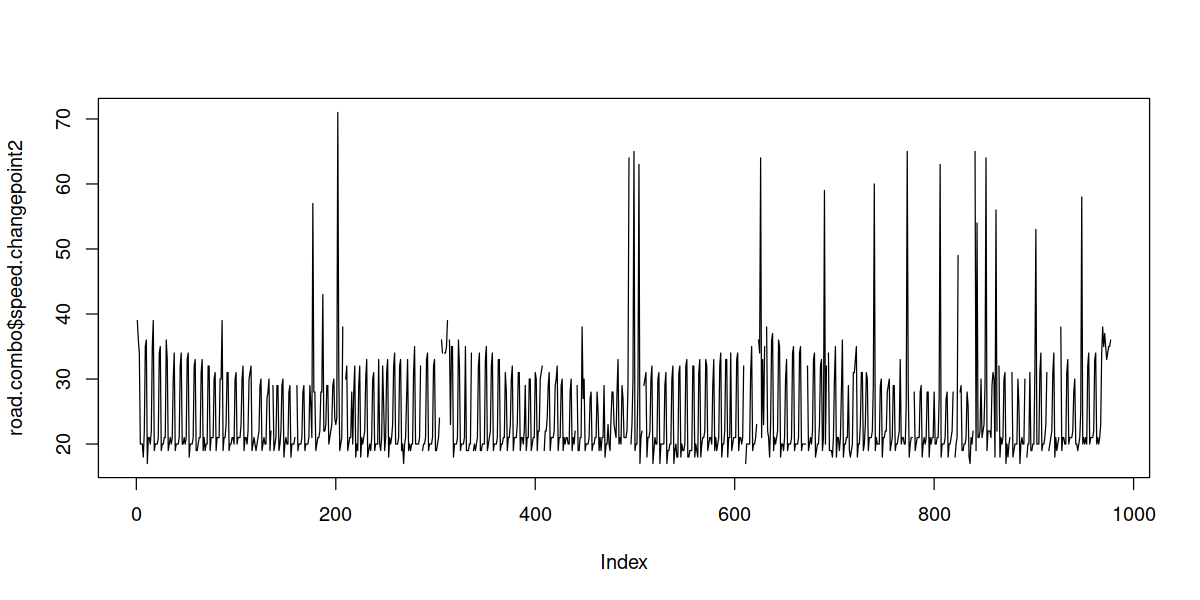

In [462]:
plot(road.combo$speed.changepoint2, type="l")

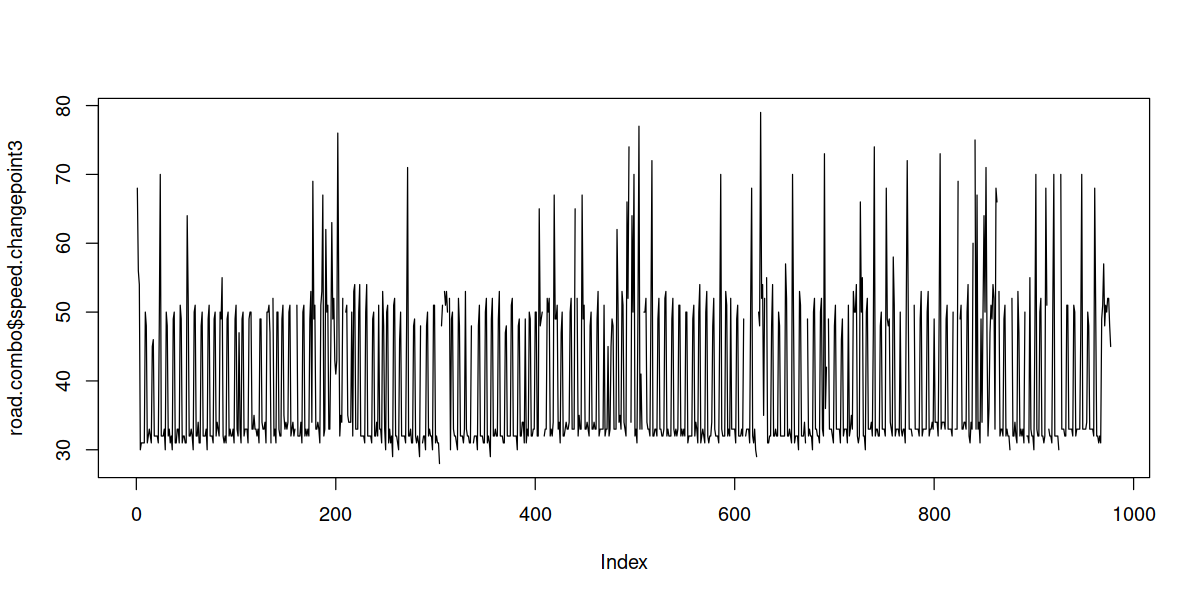

In [463]:
plot(road.combo$speed.changepoint3, type="l")

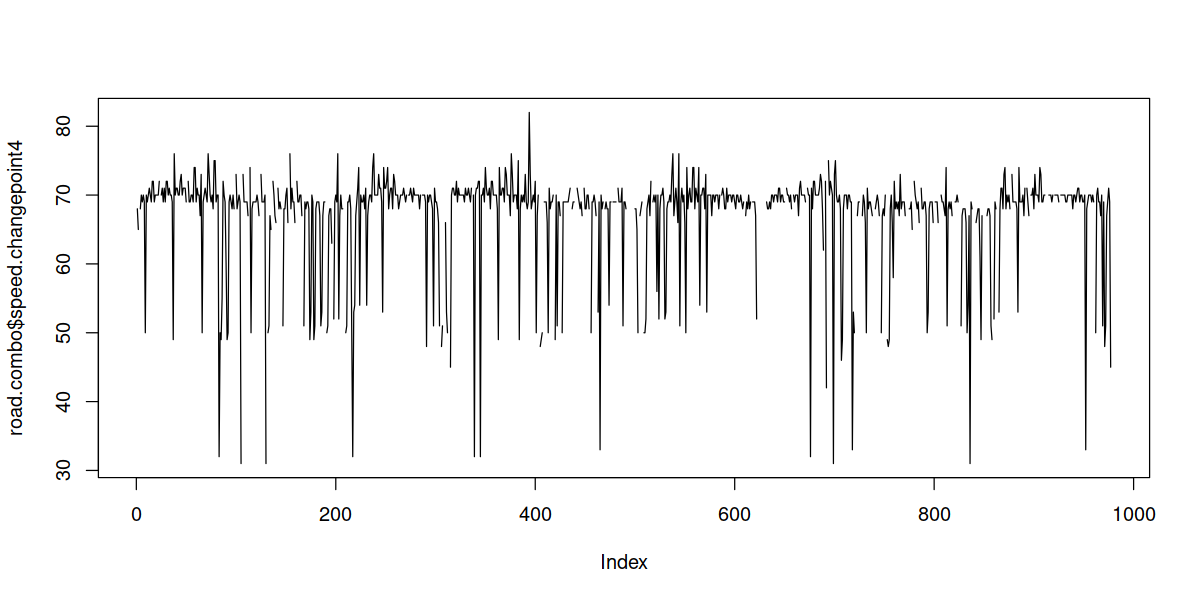

In [464]:
plot(road.combo$speed.changepoint4, type="l")

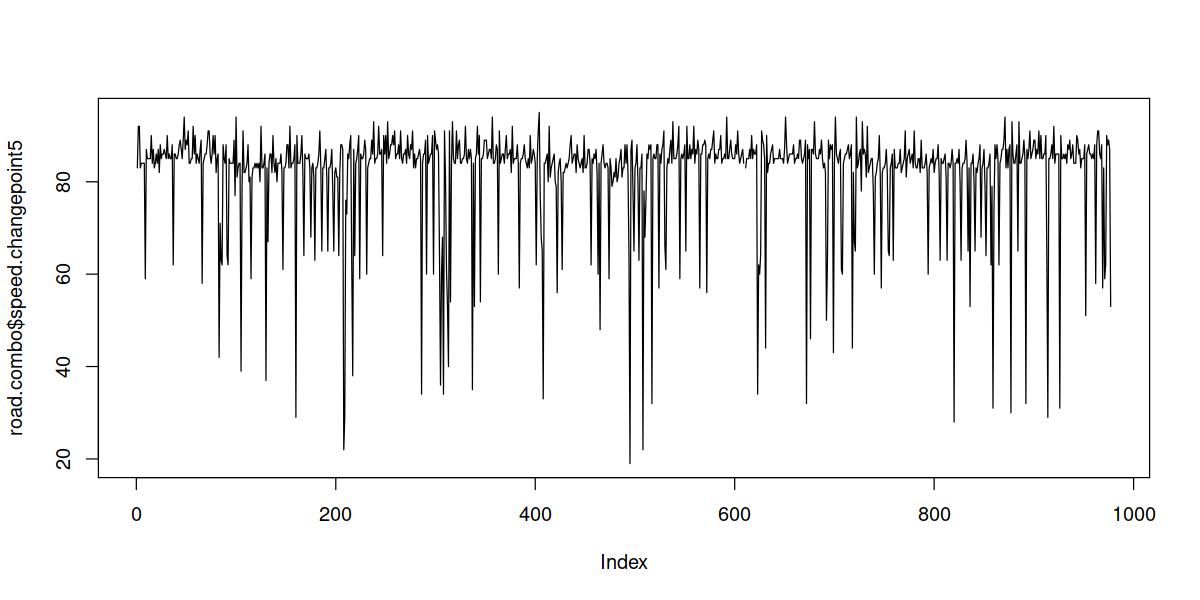

In [465]:
plot(road.combo$speed.changepoint5, type="l")

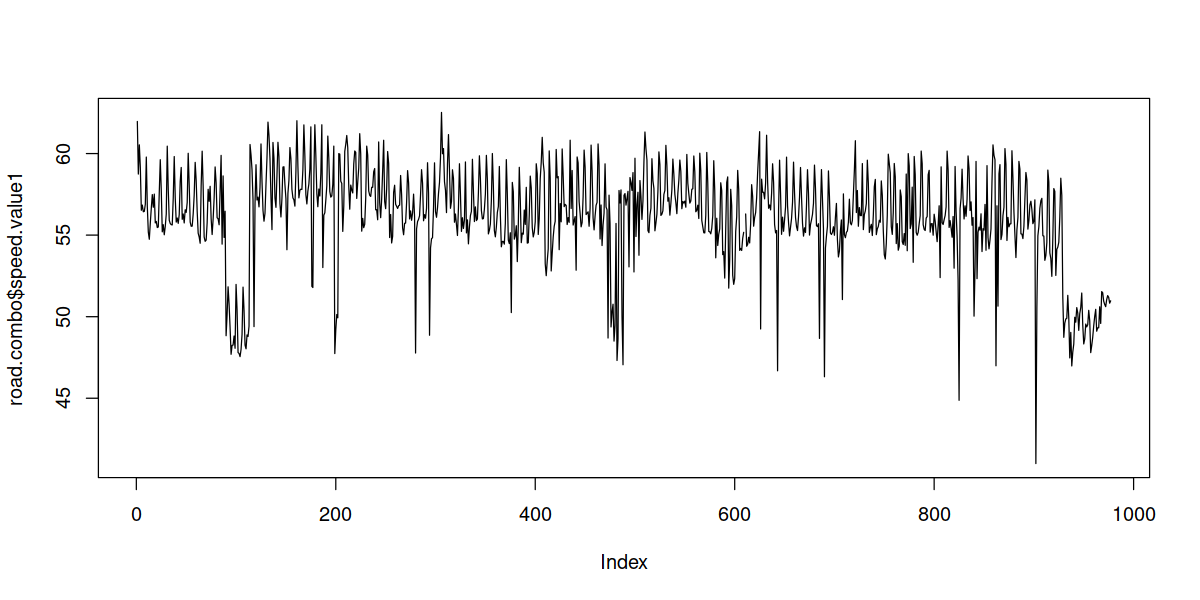

In [466]:
plot(road.combo$speed.value1, type="l")

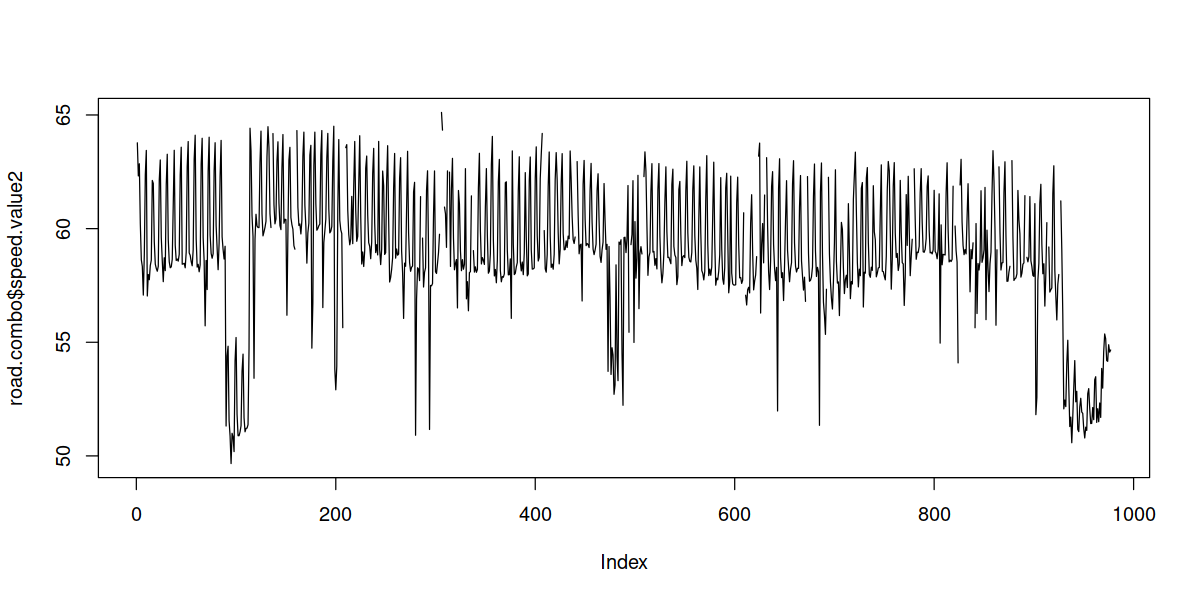

In [467]:
plot(road.combo$speed.value2, type="l")

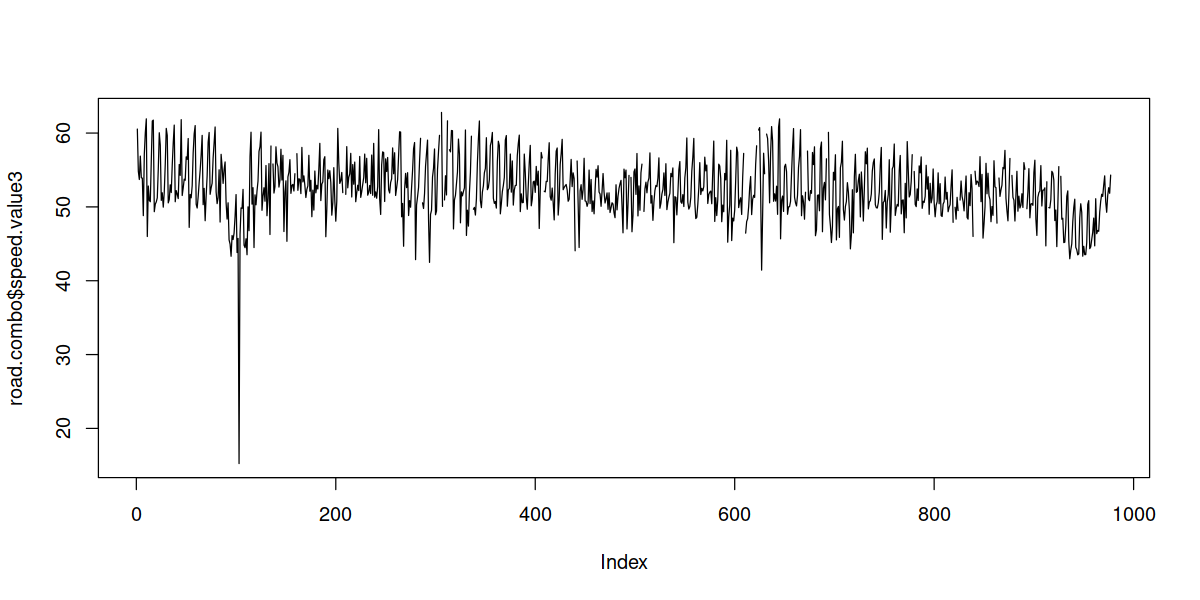

In [468]:
plot(road.combo$speed.value3, type="l")

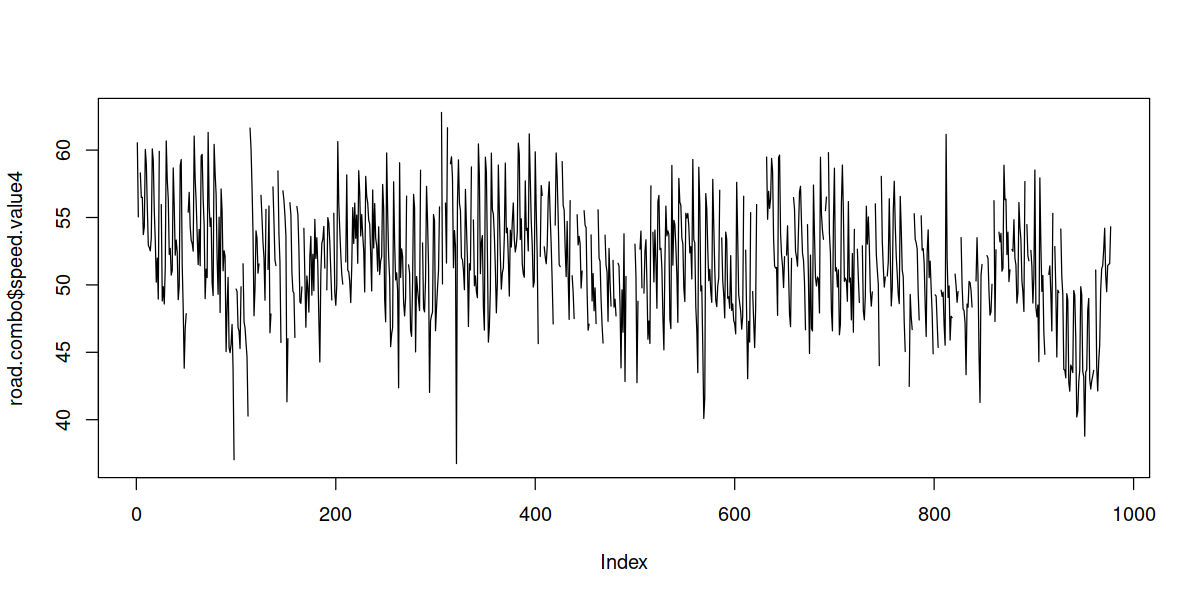

In [469]:
plot(road.combo$speed.value4, type="l")

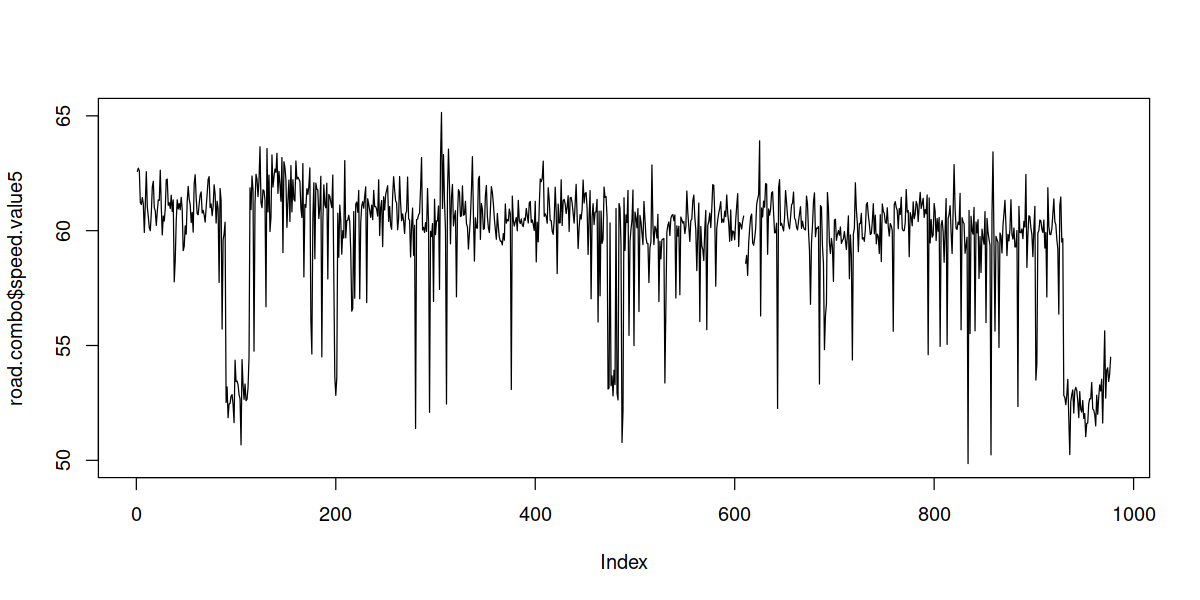

In [470]:
plot(road.combo$speed.value5, type="l")

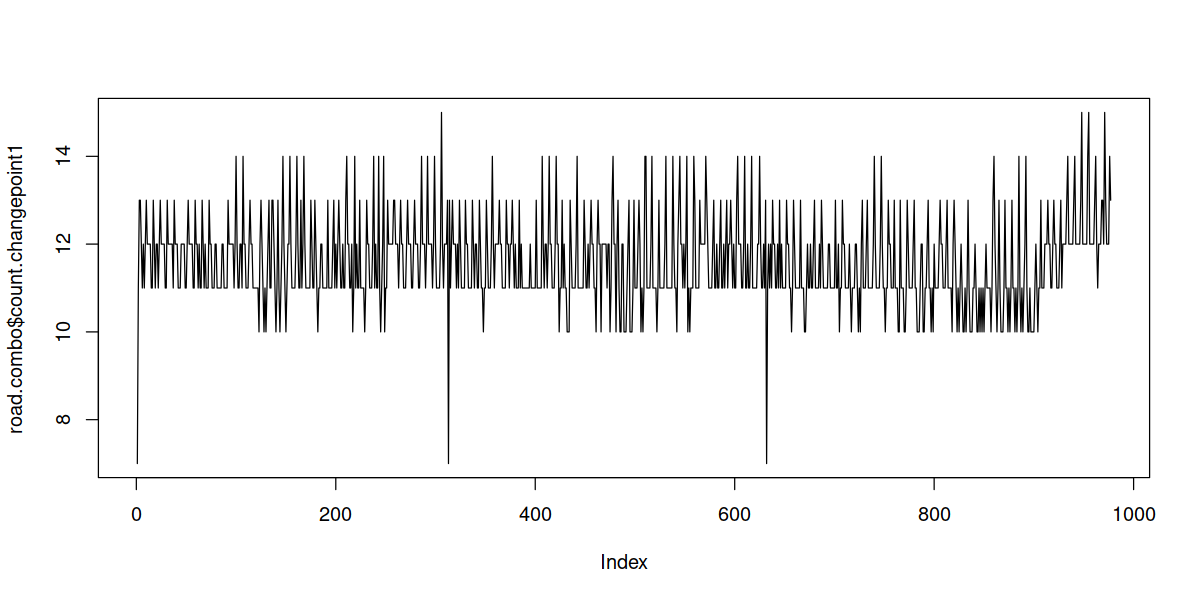

In [471]:
plot(road.combo$count.changepoint1, type="l")

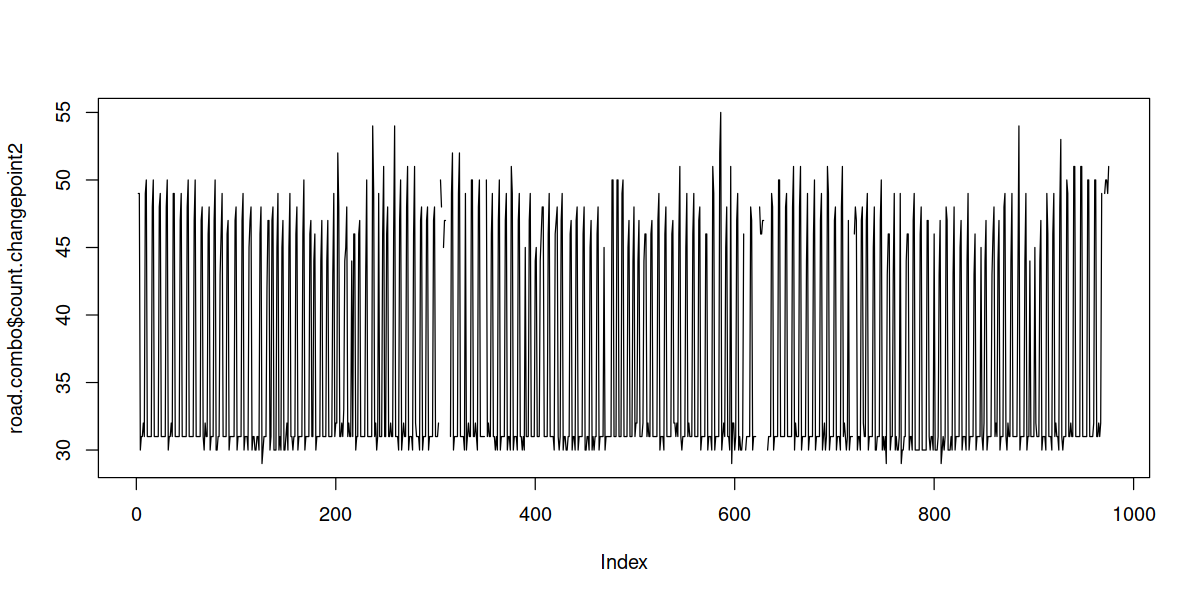

In [472]:
plot(road.combo$count.changepoint2, type="l")

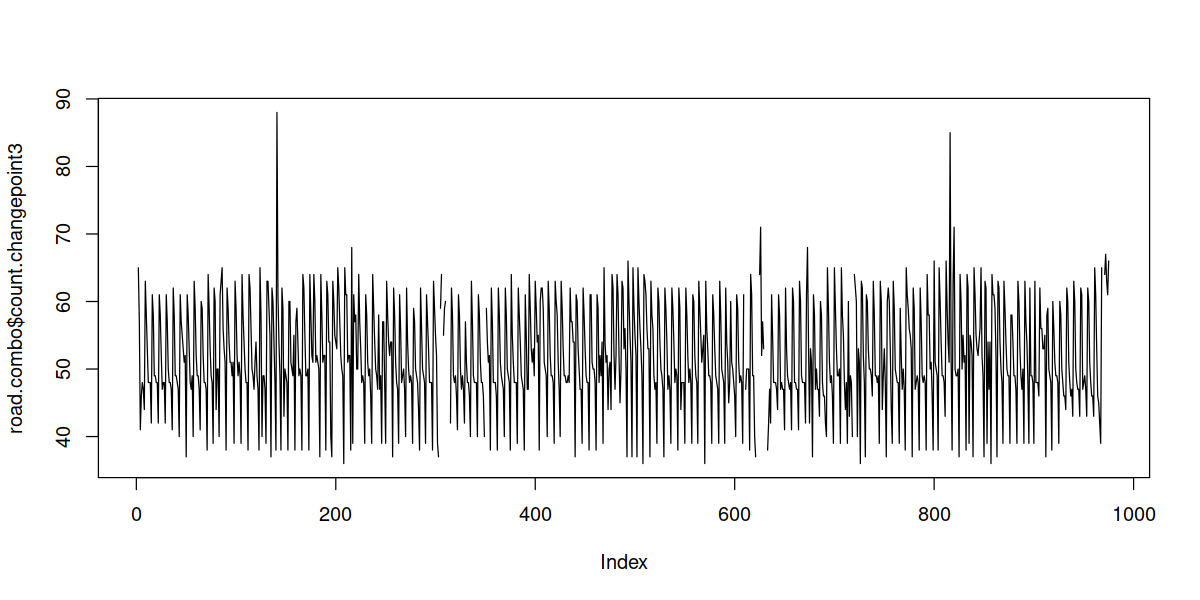

In [473]:
plot(road.combo$count.changepoint3, type="l")

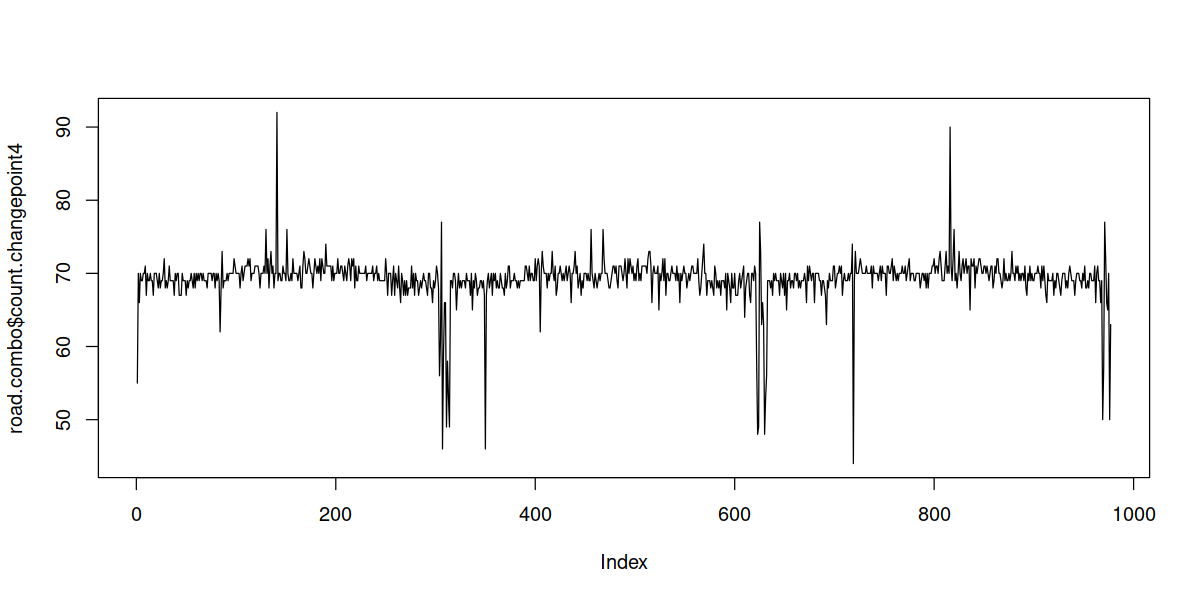

In [474]:
plot(road.combo$count.changepoint4, type="l")

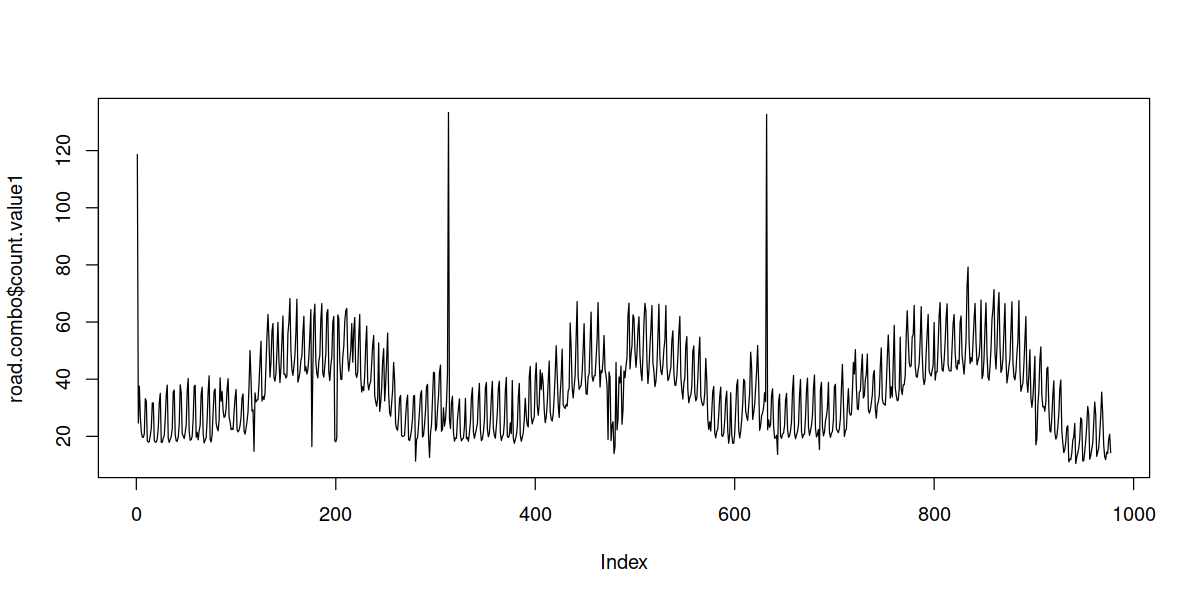

In [475]:
plot(road.combo$count.value1, type="l")

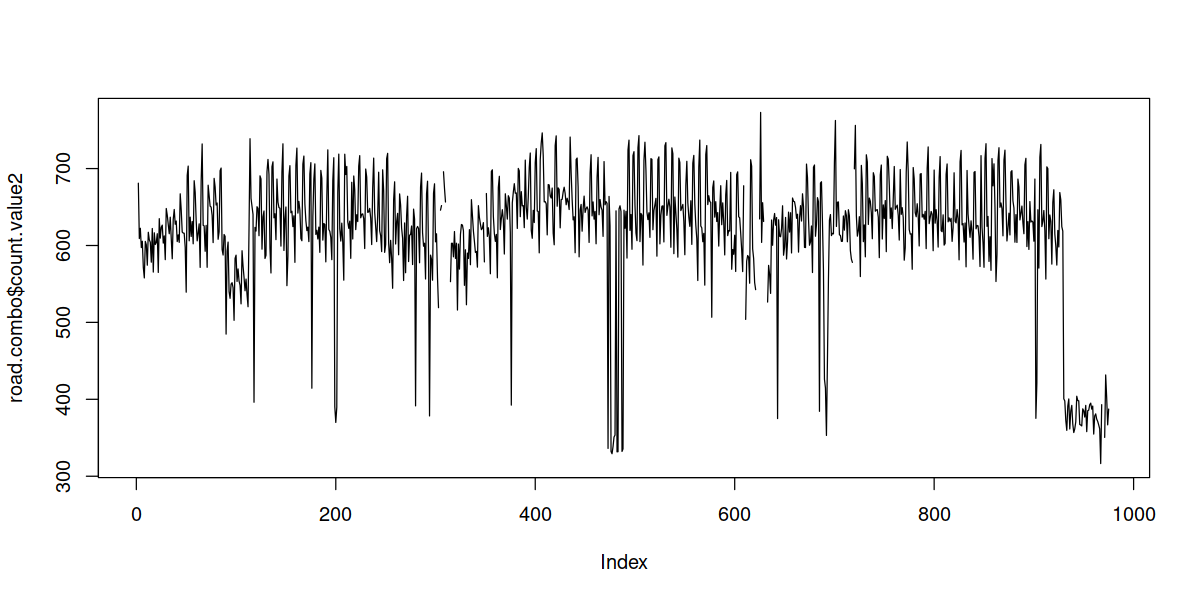

In [476]:
plot(road.combo$count.value2, type="l")

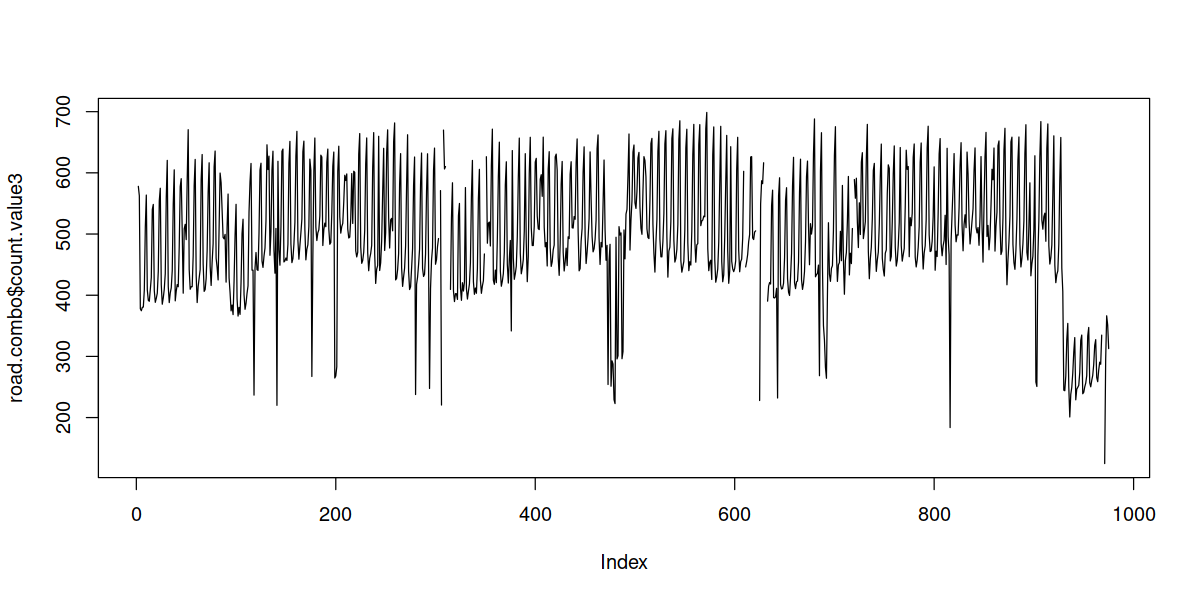

In [477]:
plot(road.combo$count.value3, type="l")

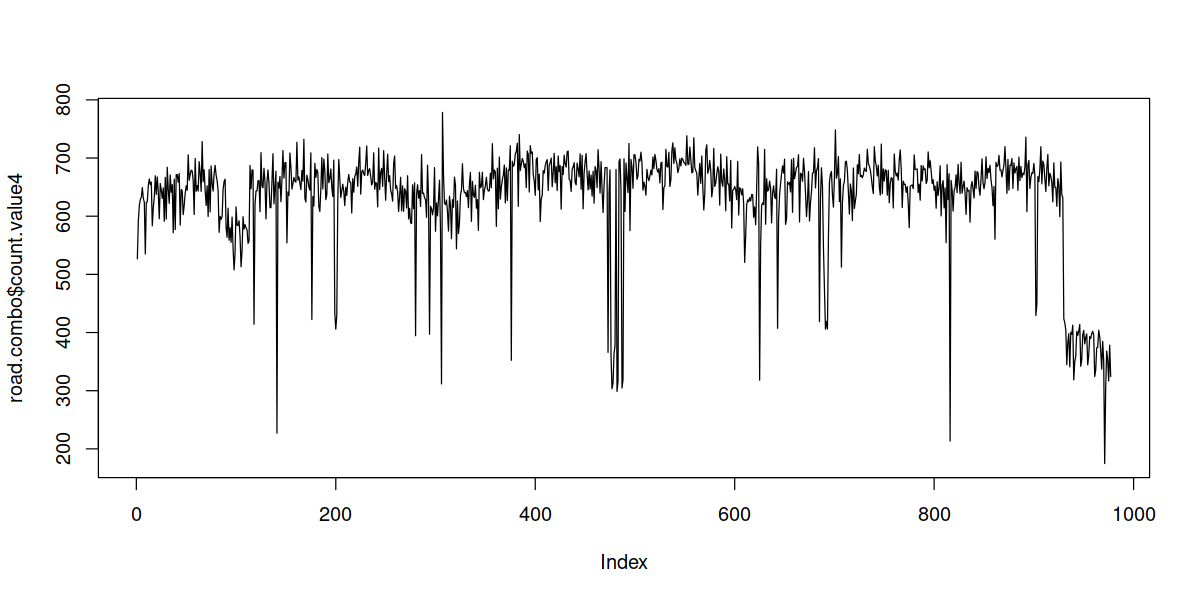

In [478]:
plot(road.combo$count.value4, type="l")

In [479]:
write.csv(road.combo, "road_features_london.csv", quote=F)